In [ ]:
!nvidia-smi

Tue Sep 20 14:45:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:09:00.0 Off |                  N/A |
| 36%   50C    P2   115W / 350W |   9275MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
BATCH_SIZE = 20
NUM_EPOCHS = 5
LEARNING_RATE=0.0001

In [ ]:
train_data = torchvision.datasets.MNIST(root='./',train=True,transform=transforms.ToTensor(),download=True)
test_data = torchvision.datasets.MNIST(root='./',train=False,transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=len(test_data),shuffle=False)

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv_layer1=nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2))

    self.conv_layer2=nn.Sequential(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2))

    self.fc1=nn.Sequential(nn.Linear(in_features=32*7*7, out_features=500),
                           nn.ReLU())

    self.fc2=nn.Linear(in_features=500, out_features=10)


  def forward(self,input_):
    out=self.conv_layer1(input_)
    out=self.conv_layer2(out)
    out=out.reshape(out.size(0),-1)
    out=self.fc1(out)
    out=self.fc2(out)
    return out

In [ ]:
def plot_loss(train_error, test_error, accuracy, steps=200):
    x=int(steps)*np.arange(0, len(train_error))

    plt.rcParams["figure.figsize"] = (18,6)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    ax1.plot(x,train_error, label='Train Error')
    ax1.plot(x,test_error, label='Test Error')
    ax1.set_title('Error Plot')
    ax1.set(xlabel='Iterations', ylabel='Average Error')
    ax1.legend(loc='upper left')
    ax1.grid()
    
  

    ax2.plot(x, accuracy, label='Accuracy')
    ax2.set_title('Model Test Accuracy')
    ax2.set(xlabel='Iterations', ylabel='Accuracy')
    ax2.grid()
    plt.show()



def plot_images(show_images, show_labels, model, bn):
    pred=model(show_images, bn=bn)
    predlabels=torch.max(pred,1)[1].cpu().numpy()
    fig=plt.figure(figsize=(10, 10))
    columns = 3
    rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i) 
        trueval=show_labels[i-1].data.cpu().numpy()
        predval=predlabels[i-1]
        a='True: '+str(trueval)+' Pred: '+str(predval)
        plt.title(a)
        plt.axis('off')
        plt.imshow(show_images[i-1].reshape(-1,28), cmap='gray')
    plt.show()

# **MODEL TRAINING**

In [ ]:
model = CNN().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

In [ ]:
%%time
import time

total_steps = len(train_loader)
cost_train,cost_test,acc = [],[],[]
training_start_time=time.time()

for epoch in range(NUM_EPOCHS):
  for i, (images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 200 == 0:
      print('Epoch:[{}/{}], Step:{}/{}, Loss:{:.6f}'.format(epoch+1,NUM_EPOCHS,i+1,total_steps,loss.item()))
      model.eval()
      with torch.no_grad():
        correct,total = 0,0
        for images,labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)

          preds = model(images)
          val_loss = criterion(preds,labels)
          _,pred = torch.max(preds.data,1)
          total += labels.size(0)
          correct += (pred == labels).sum().item()

        print('Test Loss:{:4f}, Test Accuracy:{:.4f}'.format(val_loss.item(),correct/total))
        cost_train.append(loss.item())
        acc.append(correct/total)
        cost_test.append(val_loss.item())
print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
torch.save(model.state_dict(),'model.ckpt')

Epoch:[1/5], Step:200/3000, Loss:0.849734
Test Loss:0.695792, Test Accuracy:0.8176
Epoch:[1/5], Step:400/3000, Loss:0.344382
Test Loss:0.393343, Test Accuracy:0.8913
Epoch:[1/5], Step:600/3000, Loss:0.633193
Test Loss:0.312559, Test Accuracy:0.9128
Epoch:[1/5], Step:800/3000, Loss:0.294416
Test Loss:0.277228, Test Accuracy:0.9183
Epoch:[1/5], Step:1000/3000, Loss:0.501083
Test Loss:0.228259, Test Accuracy:0.9344
Epoch:[1/5], Step:1200/3000, Loss:0.279125
Test Loss:0.227319, Test Accuracy:0.9303
Epoch:[1/5], Step:1400/3000, Loss:0.067257
Test Loss:0.199450, Test Accuracy:0.9442
Epoch:[1/5], Step:1600/3000, Loss:0.067029
Test Loss:0.201241, Test Accuracy:0.9401
Epoch:[1/5], Step:1800/3000, Loss:0.299174
Test Loss:0.167326, Test Accuracy:0.9512
Epoch:[1/5], Step:2000/3000, Loss:0.096857
Test Loss:0.156477, Test Accuracy:0.9545
Epoch:[1/5], Step:2200/3000, Loss:0.186756
Test Loss:0.144172, Test Accuracy:0.9574
Epoch:[1/5], Step:2400/3000, Loss:0.076194
Test Loss:0.135223, Test Accuracy:0.9

<font color='orange'> Training finished, took 60.46s//
CPU times: user 1min, sys: 106 ms, total: 1min 1s
Wall time: 1min </font>

1. Show the plot of training error, validation error and prediction accuracy as the training progresses. At the end of training, report the average prediction accuracy for the whole test set of 10000 images.

<font color='green'> Answer: After 5 epochs, the test Accuracy is 98.68%

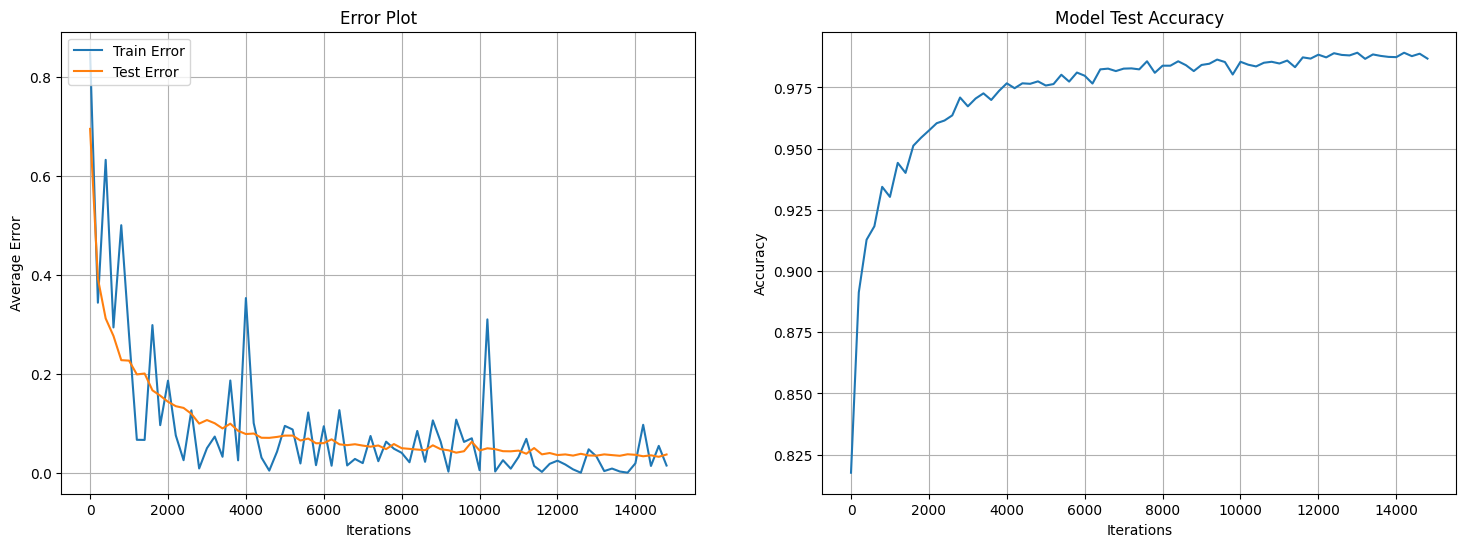

In [ ]:
plot_loss(cost_train, cost_test, acc, 200)


2. Plot randomly selected test images showing the true and predicted class labels.

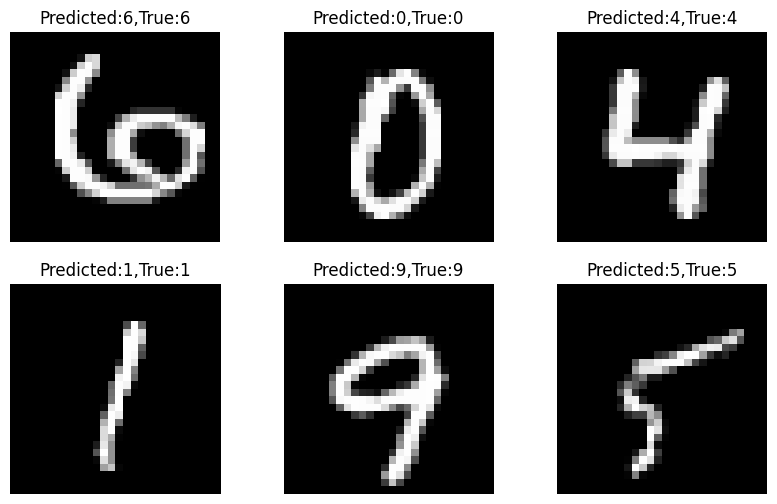

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for img,label in test_loader:
  img=img[54:76]
  img = img.to(device)
  label=label[54:76]
  label = label.to(device)
  preds = model(img)
  fig = plt.figure(figsize=(10,6))

  col,row = 3,2
  y_preds = torch.max(preds.data,1)[1].cpu().numpy()
  for i in range(1,col*row+1):
    a = fig.add_subplot(row,col,i)
    a.set_title('Predicted:{},True:{}'.format(y_preds[i-1],label.data[i-1]))
    plt. axis('off')
    plt.imshow(img[i-1,0].cpu().numpy(),cmap='gray')

  plt.show()

3. Report the dimensions of the input and output at each layer.

4. How many parameters does your network have? How many of thes are in the fully connected layers and how many are in the convolutional layers?

<font color="green">Answer:</font>


    

Layer | Input dimension | Output dimension | Number of Parameters(Weights)| Number of Parameters(biases)| Total Number of Parameters
    ----------|-------------------|-----------------|----------|--------|-----------
    layer1.conv1 | 28,28,1| 28,28,32| W=3* 3* 32= 288 | b=32 | 288+32 = **320**
    layer1.maxpool | 28,28,32 | 14,14,32| 0 | 0| 0
    layer2.conv2 | 14,14,32 | 14,14,32| W=(3* 3 * 32 )* 32= 9216| b=32| 9216+32=**9248**
    layer2.maxpool| 14,14,32 | 7,7,32| 0|0|0
    fully_connected1 | 7*7*32 = 1568 | 500 (given) | W=1568* 500 =<font color='red'> 7.84L</font>| b=500 | 7.84L+500= **<font color='red'>7.845L</font>** 
    fully_connected2 | 500 | 10 (num_classes)| W=500* 10= 5000| b=10 | 5000+10=**5010**


    

    
Total Number of parameters          : 7,99,078 ~ 8L

Number of parameters in FC layers   : **<font color='red'>7,89,510</font>** 

Number of parameters in Conv layers : 9568

5. How many neurons does your network have? How many of these are in the fully connected layers and how many are in the convolutional layers?


<font color='green'>Answer: </font>
    
Layer | Neurons
    ------|---------
    Layer1| 3* 3* 32= 288
    Layer2| 3* 3* 32* 32= 9216
    FC1 | 500
    FC2|10

# **MODEL TRAINING USING BATCH NORMALISATION**

6. Use batch-normalization. Does it improve the test accuracy? Does it affect training time?

In [ ]:
class CNN_BN(nn.Module):
  def __init__(self):
    super(CNN_BN,self).__init__()
    self.conv_layer1=nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
                                nn.ReLU(),
                                nn.BatchNorm2d(32),
                                nn.MaxPool2d(kernel_size=2, stride=2))

    self.conv_layer2=nn.Sequential(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
                                nn.ReLU(),
                                nn.BatchNorm2d(32),
                                nn.MaxPool2d(kernel_size=2, stride=2))

    self.fc1=nn.Sequential(nn.Linear(in_features=32*7*7, out_features=500),
                           nn.ReLU())

    self.fc2=nn.Linear(in_features=500, out_features=10)



  def forward(self,input_):
    out=self.conv_layer1(input_)
    out=self.conv_layer2(out)
    out=out.reshape(out.size(0),-1)
    out=self.fc1(out)
    out=self.fc2(out)
    return out

In [ ]:
model_bn = CNN_BN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_bn.parameters(),lr=LEARNING_RATE)

In [ ]:
%%time
import time

total_steps = len(train_loader)
cost_train_bn,cost_test_bn,acc_bn = [],[],[]
training_start_time = time.time()

for epoch in range(NUM_EPOCHS):
  for i, (images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model_bn(images)
    loss = criterion(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 200 == 0:
      print('Epoch:[{}/{}], Step:{}/{}, Loss:{:.6f}'.format(epoch+1,NUM_EPOCHS,i+1,total_steps,loss.item()))
      model_bn.eval()
      with torch.no_grad():
        correct,total = 0,0
        for images,labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)

          preds = model_bn(images)
          val_loss = criterion(preds,labels)
          _,pred = torch.max(preds.data,1)
          total += labels.size(0)
          correct += (pred == labels).sum().item()

        print('Test Loss:{:4f}, Test Accuracy:{:.4f}'.format(val_loss.item(),correct/total))
        cost_train_bn.append(loss.item())
        acc_bn.append(correct/total)
        cost_test_bn.append(val_loss.item())
        
print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
torch.save(model_bn.state_dict(),'model_bn.ckpt')

Epoch:[1/5], Step:200/3000, Loss:0.347887
Test Loss:0.254821, Test Accuracy:0.9329
Epoch:[1/5], Step:400/3000, Loss:0.065046
Test Loss:0.127743, Test Accuracy:0.9611
Epoch:[1/5], Step:600/3000, Loss:0.122614
Test Loss:0.104515, Test Accuracy:0.9694
Epoch:[1/5], Step:800/3000, Loss:0.041508
Test Loss:0.100825, Test Accuracy:0.9690
Epoch:[1/5], Step:1000/3000, Loss:0.142908
Test Loss:0.085262, Test Accuracy:0.9748
Epoch:[1/5], Step:1200/3000, Loss:0.205248
Test Loss:0.082362, Test Accuracy:0.9746
Epoch:[1/5], Step:1400/3000, Loss:0.064580
Test Loss:0.067769, Test Accuracy:0.9791
Epoch:[1/5], Step:1600/3000, Loss:0.385200
Test Loss:0.073187, Test Accuracy:0.9775
Epoch:[1/5], Step:1800/3000, Loss:0.009780
Test Loss:0.059134, Test Accuracy:0.9827
Epoch:[1/5], Step:2000/3000, Loss:0.006281
Test Loss:0.055794, Test Accuracy:0.9820
Epoch:[1/5], Step:2200/3000, Loss:0.052190
Test Loss:0.052710, Test Accuracy:0.9832
Epoch:[1/5], Step:2400/3000, Loss:0.074574
Test Loss:0.048072, Test Accuracy:0.9

<font color='orange'>Training finished, took 66.55s//
CPU times: user 1min 7s, sys: 112 ms, total: 1min 7s
Wall time: 1min 6s</font>

<font color='green'> The model **after** batch normalisation takes more time (66.55s) to train and has test accuracy of 98.48%

The model **before** batch normalisation takes lesser time (60.46s) to train and has test accuracy of 98.68% .</font>

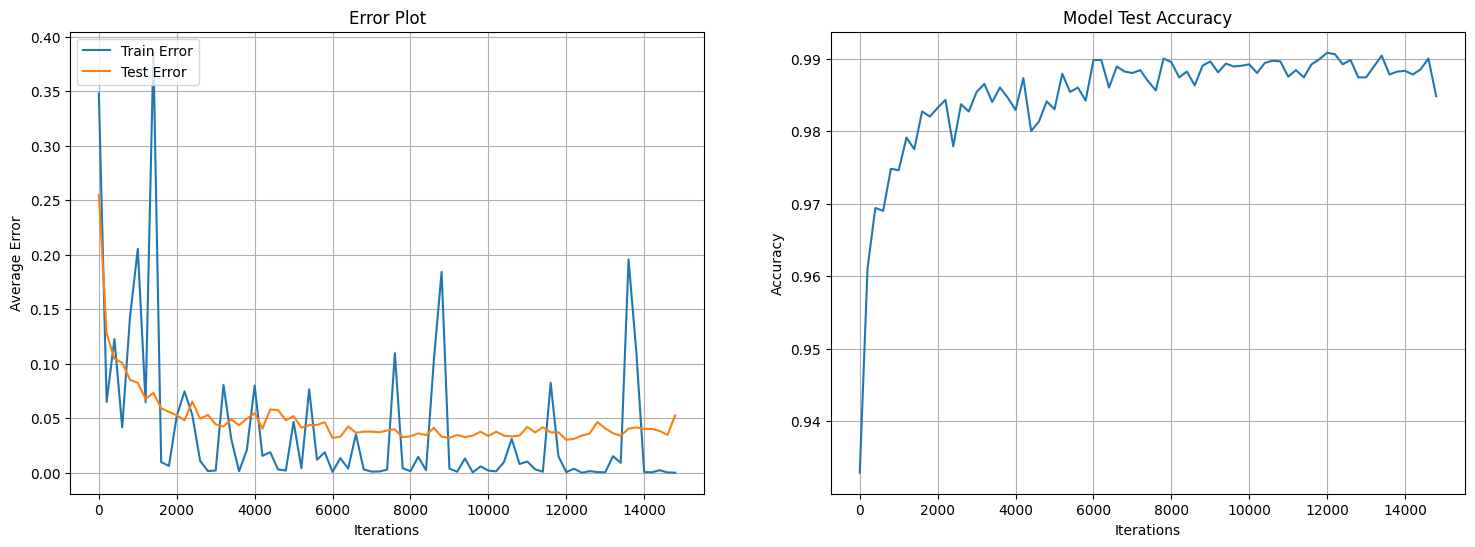

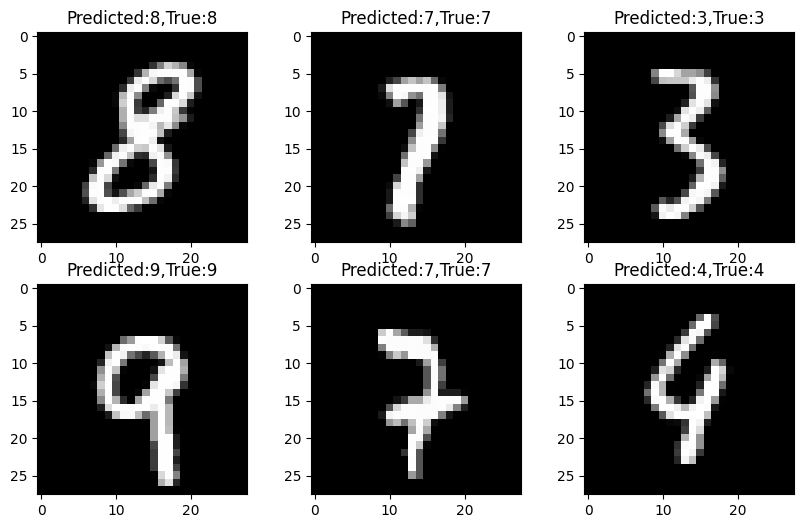

In [ ]:
plot_loss(cost_train_bn, cost_test_bn, acc_bn, 200)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for img,label in test_loader:
  img=img[110:116]
  img = img.to(device)
  label=label[110:116]
  label = label.to(device)
  preds = model_bn(img)
  fig = plt.figure(figsize=(10,6))
  fig.tight_layout()
  col,row = 3,2
  y_preds = torch.max(preds.data,1)[1].cpu().numpy()
  for i in range(1,col*row+1):
    a = fig.add_subplot(row,col,i)
    a.set_title('Predicted:{},True:{}'.format(y_preds[i-1],label.data[i-1]))
    plt.imshow(img[i-1,0].cpu().numpy(),cmap='gray')

  plt.show()
  break


# **VISUALIZING FILTERS**

In [ ]:
checkpoint = torch.load('model.ckpt')
model = CNN().to(device)
model.load_state_dict(checkpoint)
model.eval()
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

conv_layer1.0.weight 	 torch.Size([32, 1, 3, 3])
conv_layer1.0.bias 	 torch.Size([32])
conv_layer2.0.weight 	 torch.Size([32, 32, 3, 3])
conv_layer2.0.bias 	 torch.Size([32])
fc1.0.weight 	 torch.Size([500, 1568])
fc1.0.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])


In [ ]:
l1_weights = model.state_dict()['conv_layer1.0.weight'].cpu().numpy()
l2_weights = model.state_dict()['conv_layer2.0.weight'].cpu().numpy()

In [ ]:
def normalize(x,eps=1e-8):
  out = np.zeros_like(x)
  for i in range(x.shape[0]):
    high,low = np.amax(x[i]),np.amin(x[i])
    out[i] = (x[i]-low)/(high-low+eps)
  
  out = out*255
  out = out.astype(np.uint8)
  return out

l1_weights_normalized = normalize(l1_weights)
l2_weights_normalized = normalize(l2_weights)

In [ ]:
print(l1_weights_normalized.shape)

(32, 1, 3, 3)


In [ ]:
l1_weights_normalized = l1_weights_normalized.reshape(32,3,3)

In [ ]:
print(l2_weights_normalized.shape)

(32, 32, 3, 3)


1. Plot the the conv1 layer filters. Do you observe interesting patterns?

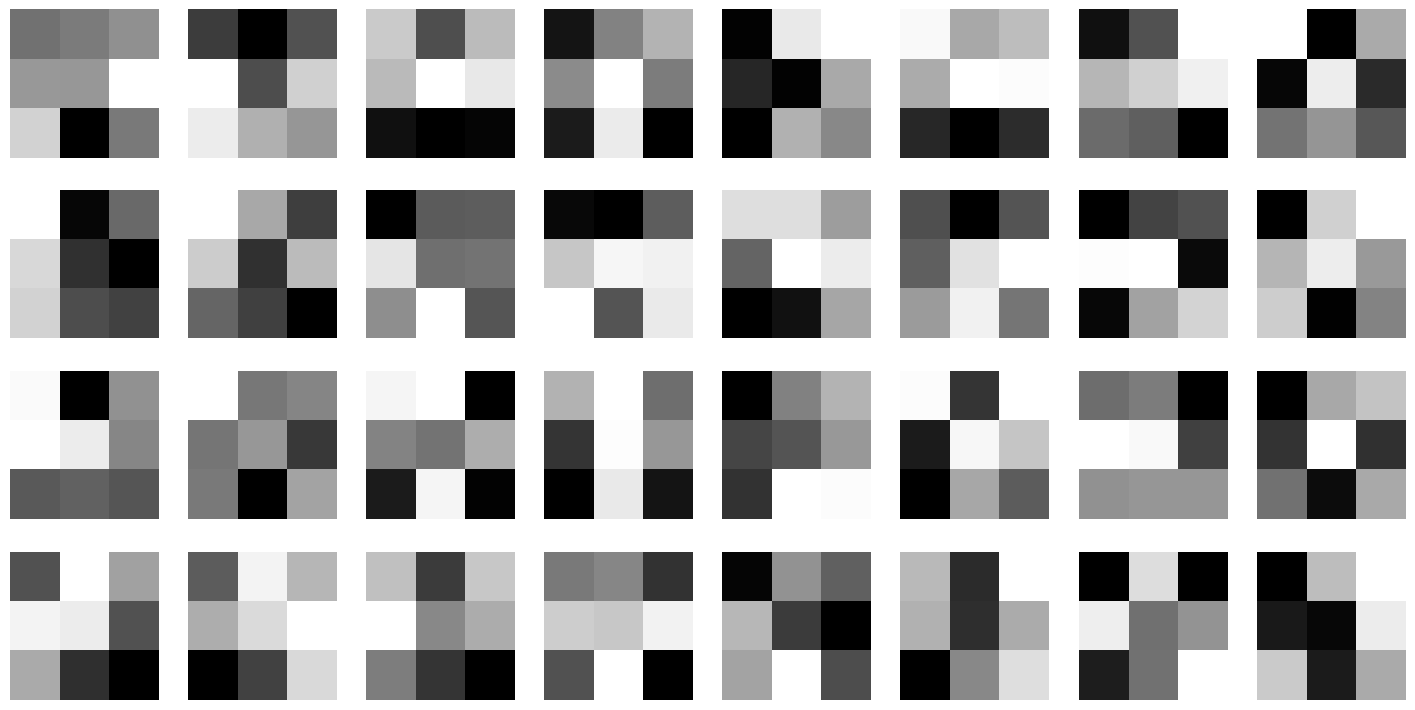

In [ ]:
fig = plt.figure(figsize=(18,9))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(l1_weights_normalized[i-1],cmap='gray')
  plt.axis("off")

plt.show()

2. Plot filters of a higher layer and compare them with conv1 layer filters.

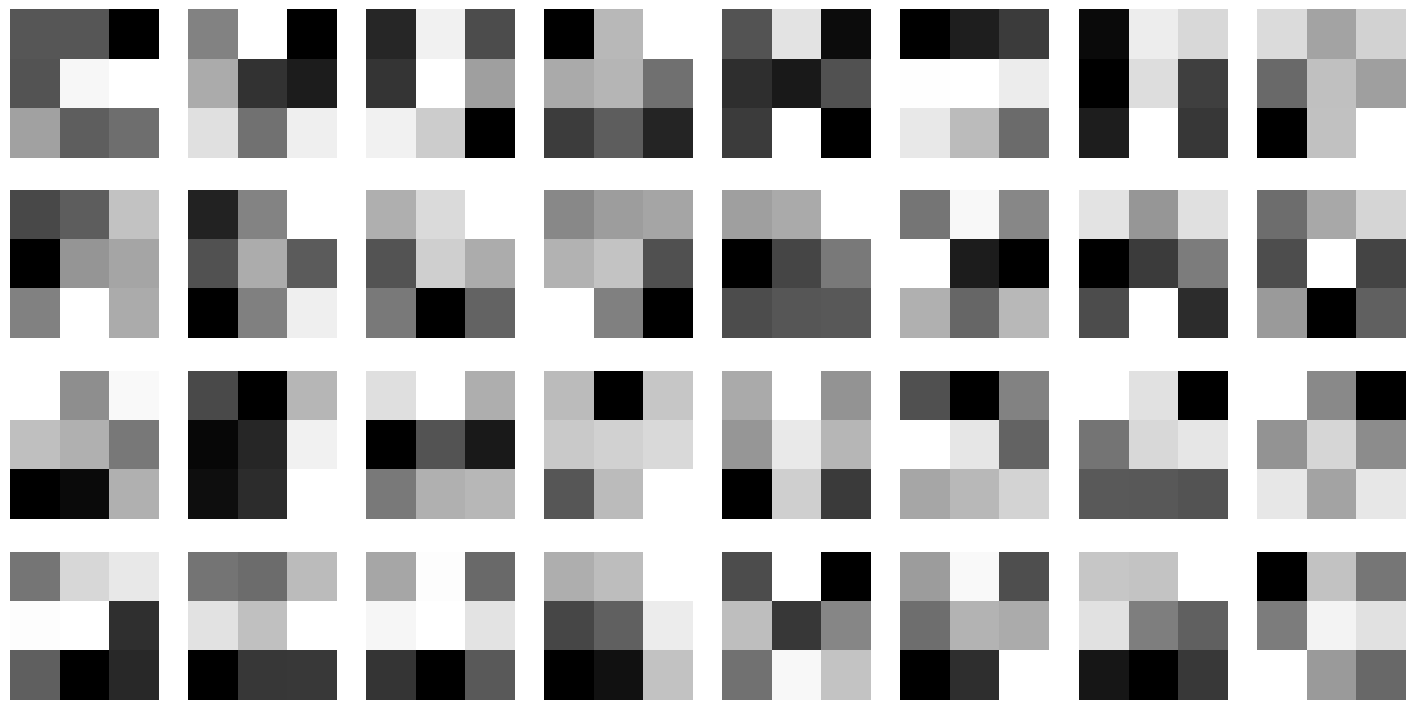

In [ ]:
fig = plt.figure(figsize=(18,9))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(l2_weights_normalized[i-1,10],cmap='gray')
  plt.axis("off")
plt.show()

<font color='green'>From the plotted filter images, it is very difficult to conclude anything about the patterns but as discussed in the class we know that the initial layer filters look at the lower level features as edges whereas the higher level features are captured by filters in the deeper layers. As our network is not very deep, arriving at any conclusion is difficult.

# **VISUALISING ACTIVATIONS**

3. Visualize the activations of the convolutional layers. What do you observe as you go deeper?

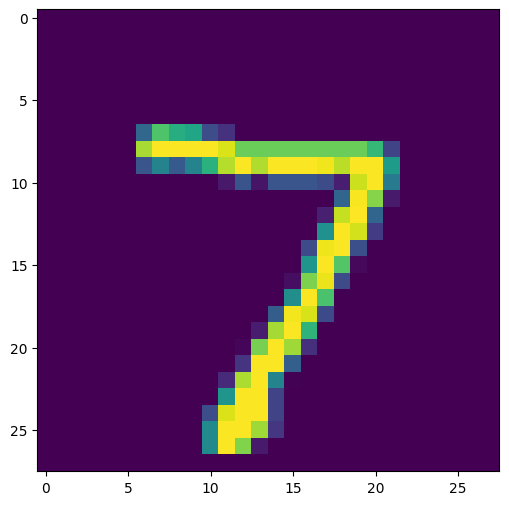

conv_layer1 output shape: (32, 14, 14)
conv_layer2 output shape: (32, 7, 7)


In [ ]:
#visualising first test image
for img,label in test_loader:
    test_image = img[0].to(device)
    test_label = label[0].to(device)
    img = test_image.cpu().numpy().reshape(28,28)
    plt.imshow(img)
    plt.show()

    layer1_out = model.conv_layer1(torch.reshape(test_image,(1,1,28,28)))
    layer1_out_np = layer1_out.cpu().detach().numpy().reshape(32,14,14)
    print('conv_layer1 output shape:',layer1_out_np.shape)

    layer2_out = model.conv_layer2(layer1_out)
    layer2_out_np = layer2_out.cpu().detach().numpy().reshape(32,7,7)
    print('conv_layer2 output shape:',layer2_out_np.shape)

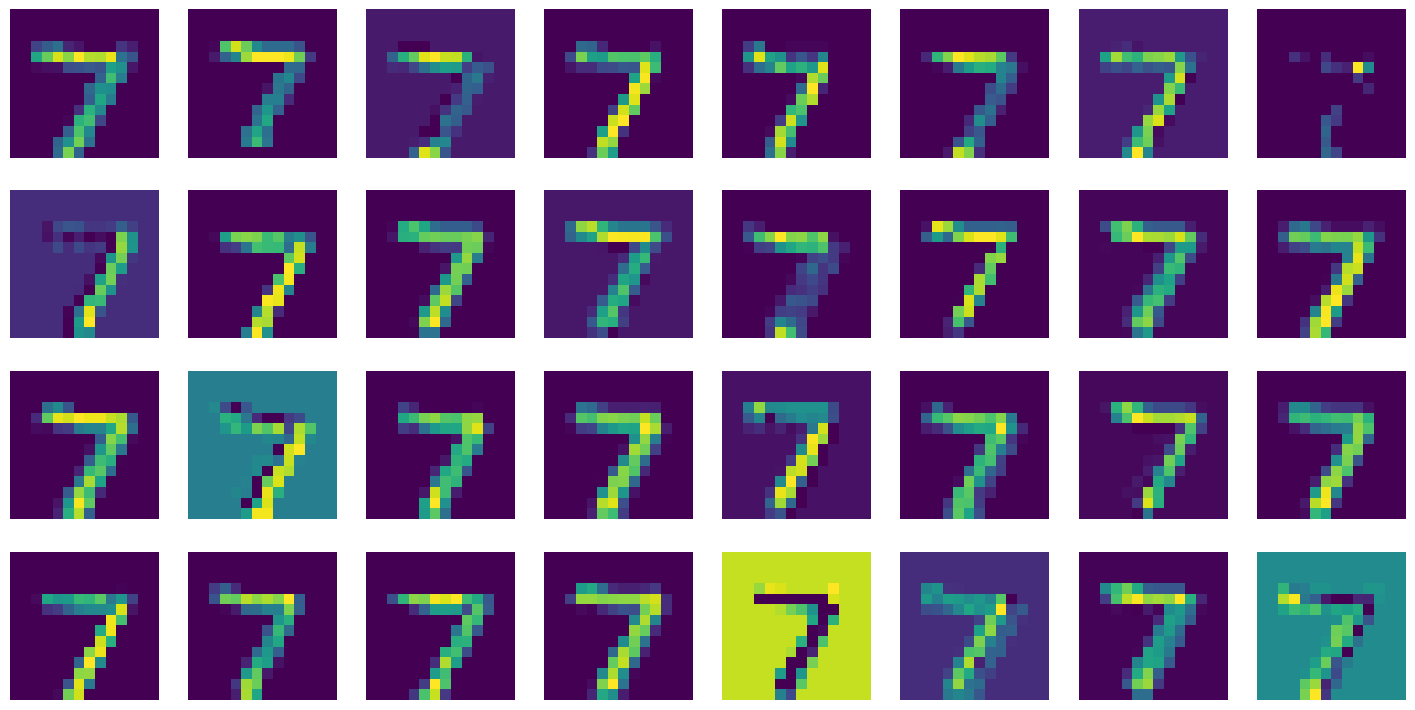

In [ ]:
fig = plt.figure(figsize=(18,9))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(layer1_out_np[i-1])
  plt.axis("off")
plt.show()

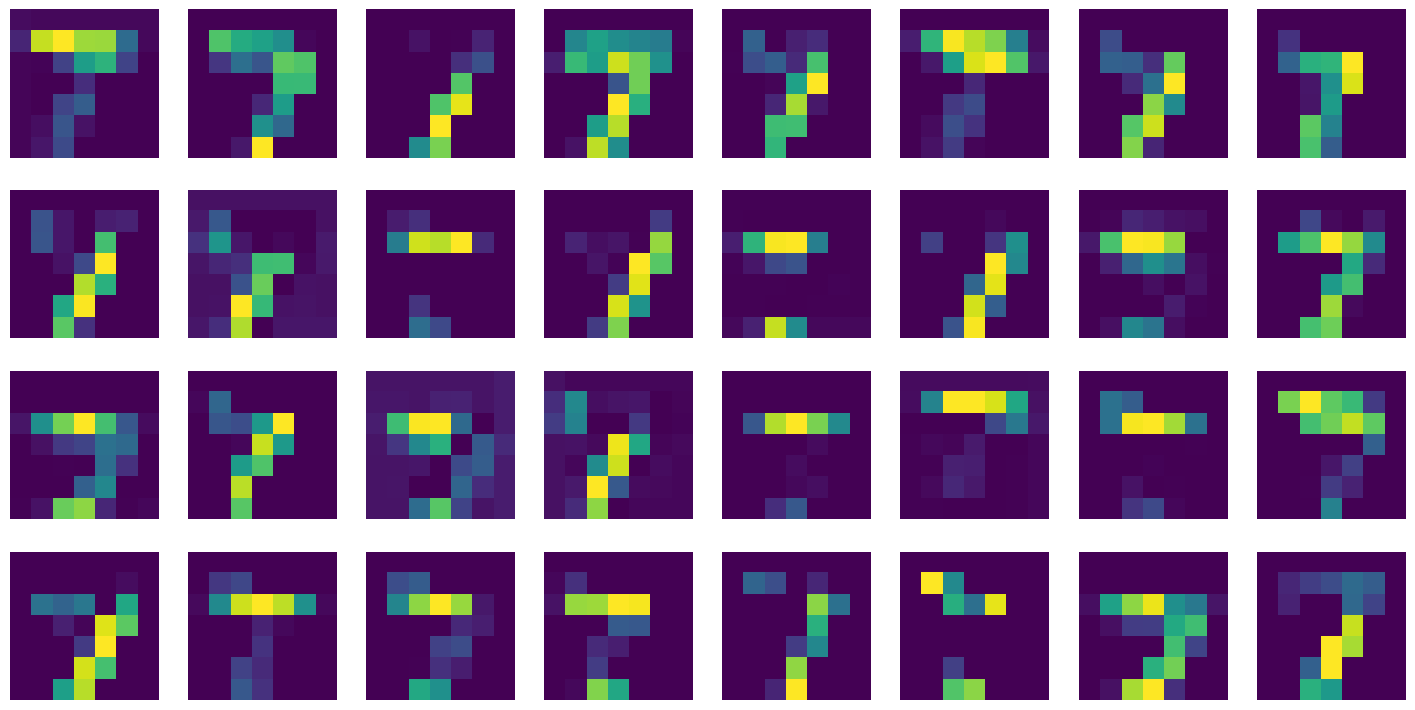

In [ ]:
fig = plt.figure(figsize=(18,9))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(layer2_out_np[i-1])
  plt.axis("off")
plt.show()

<font color='green'>From above, We can see that the lower level feature maps are more focussed towards the edges and the higher level feature maps are looking at the overall image(features) of the digit.

# **OCCLUDING PARTS OF IMAGE**

4. Occluding parts of the image : Suppose that the network classifies an image of a digit successfully. How can we be certain that it is actually observing the main part of the digit in the image as opposed to background or something else?

In [ ]:
def occluded_image(input_image,location,patch_size=7):
  input_image_copy = input_image.copy()
  x=int(location[0])
  y=int(location[1])
  input_image_copy[x:x+patch_size,y:y+patch_size] = 0.5
  return input_image_copy

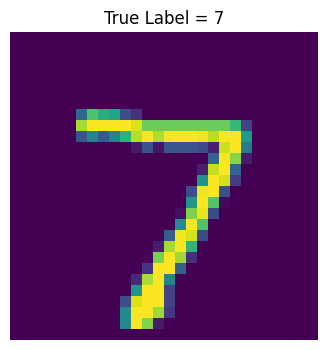

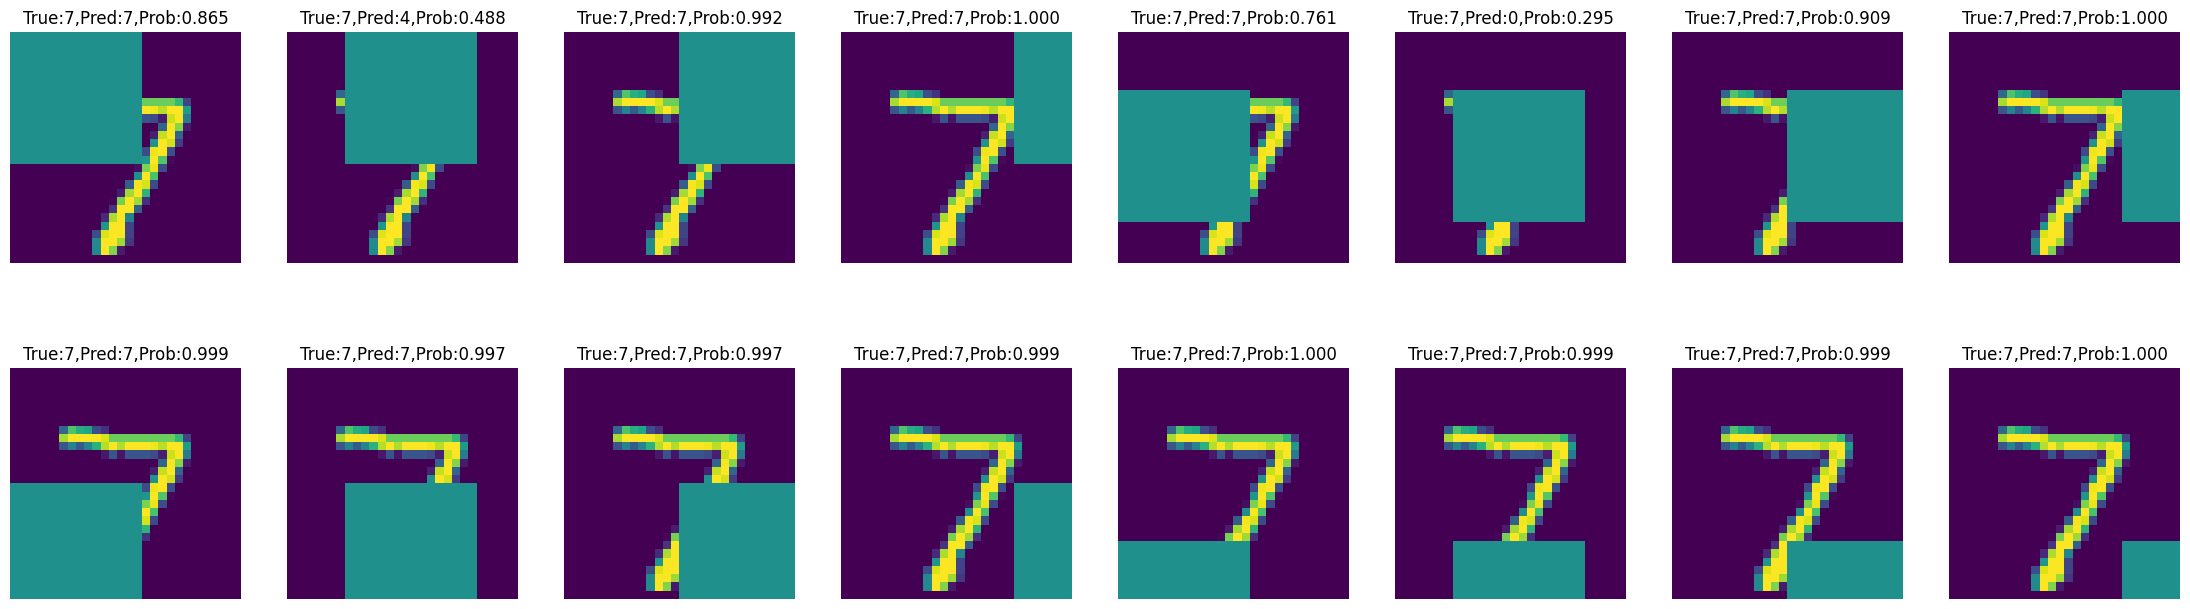

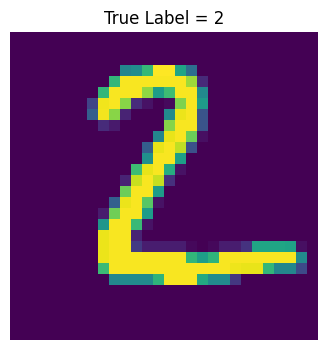

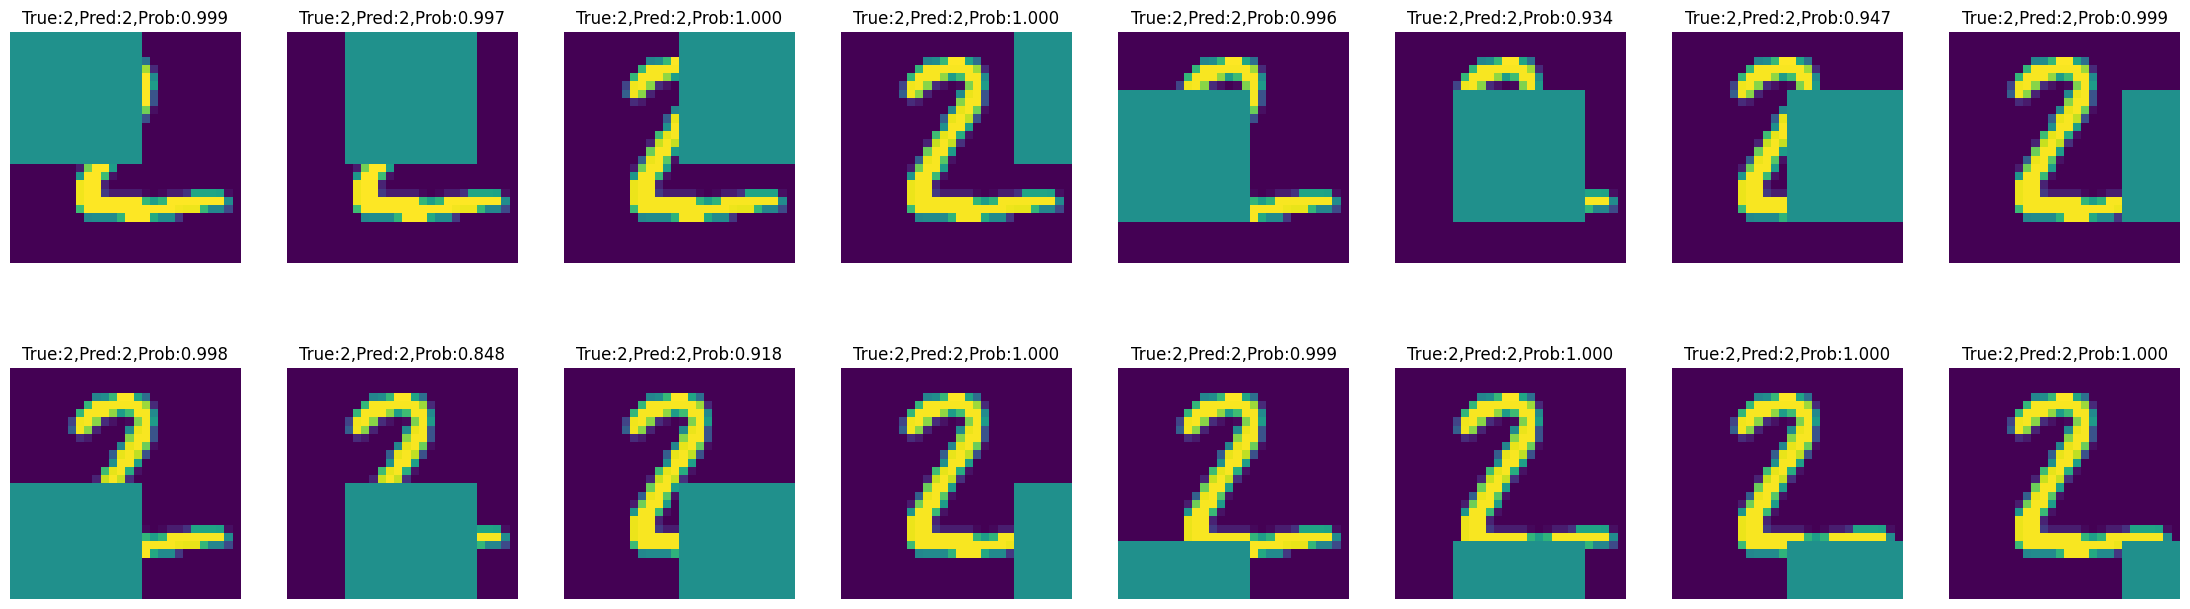

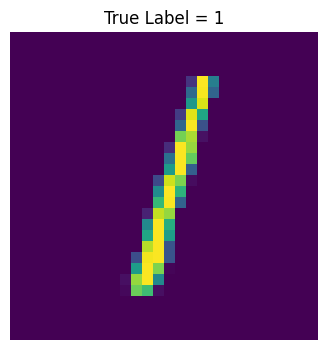

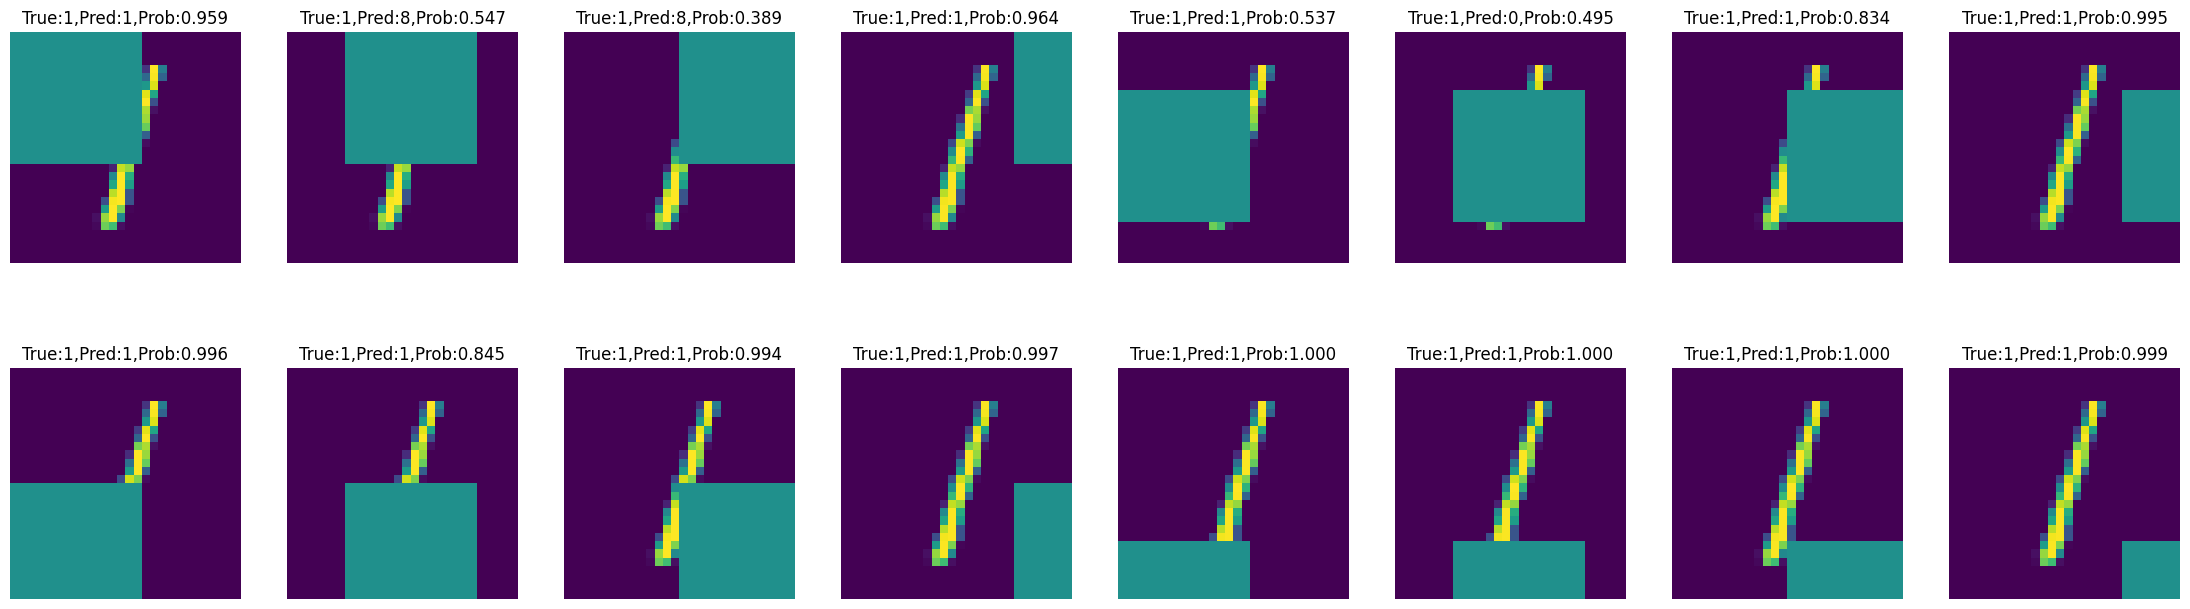

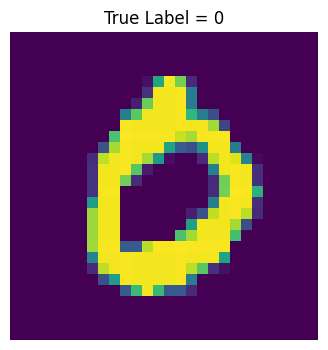

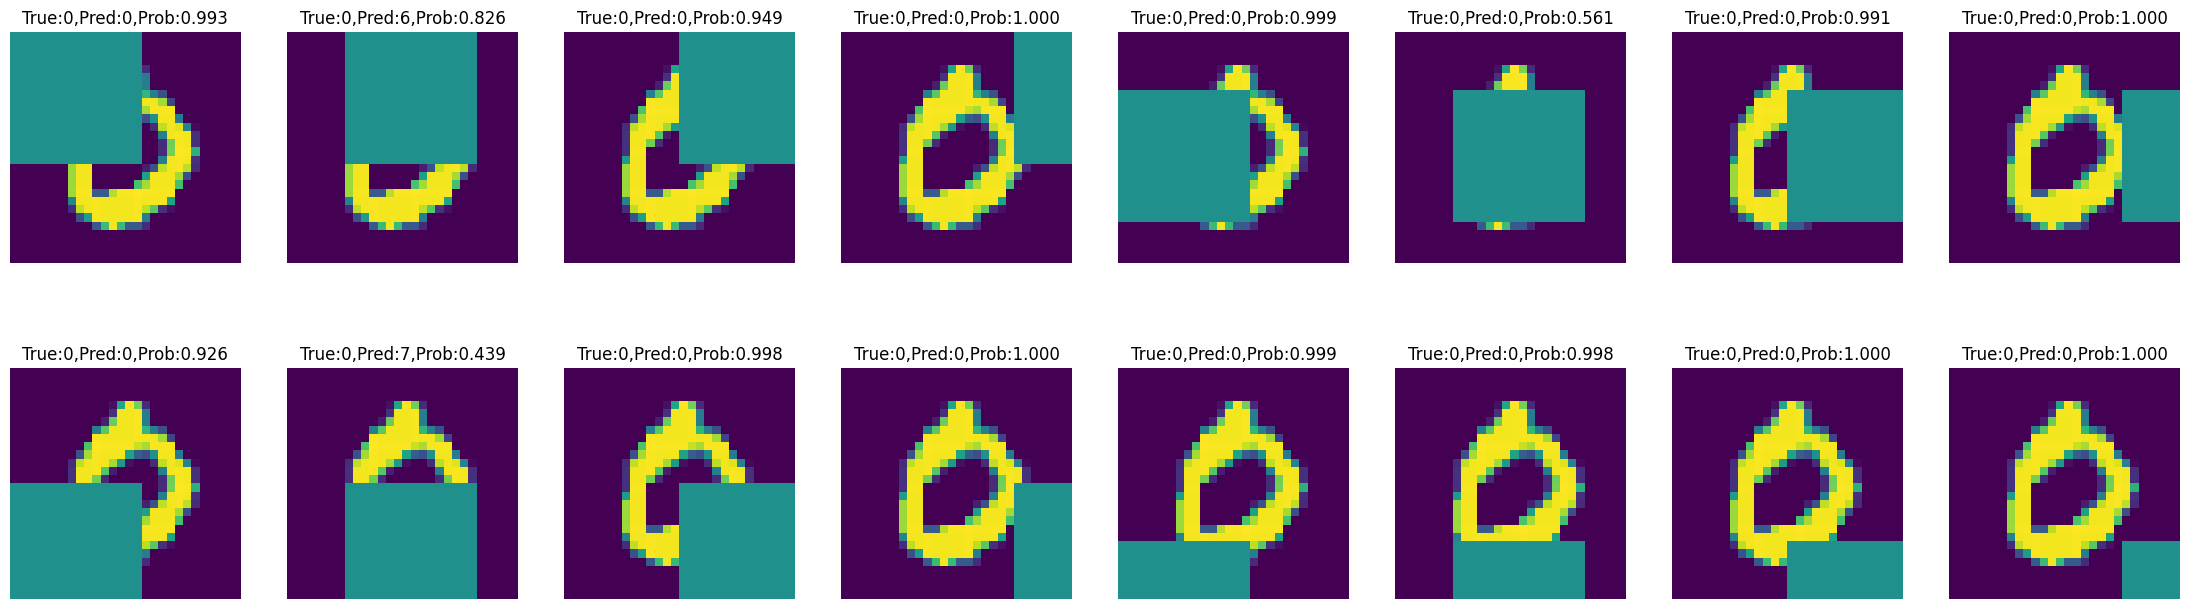

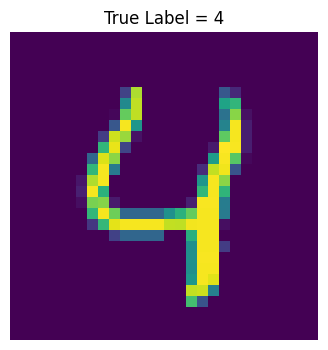

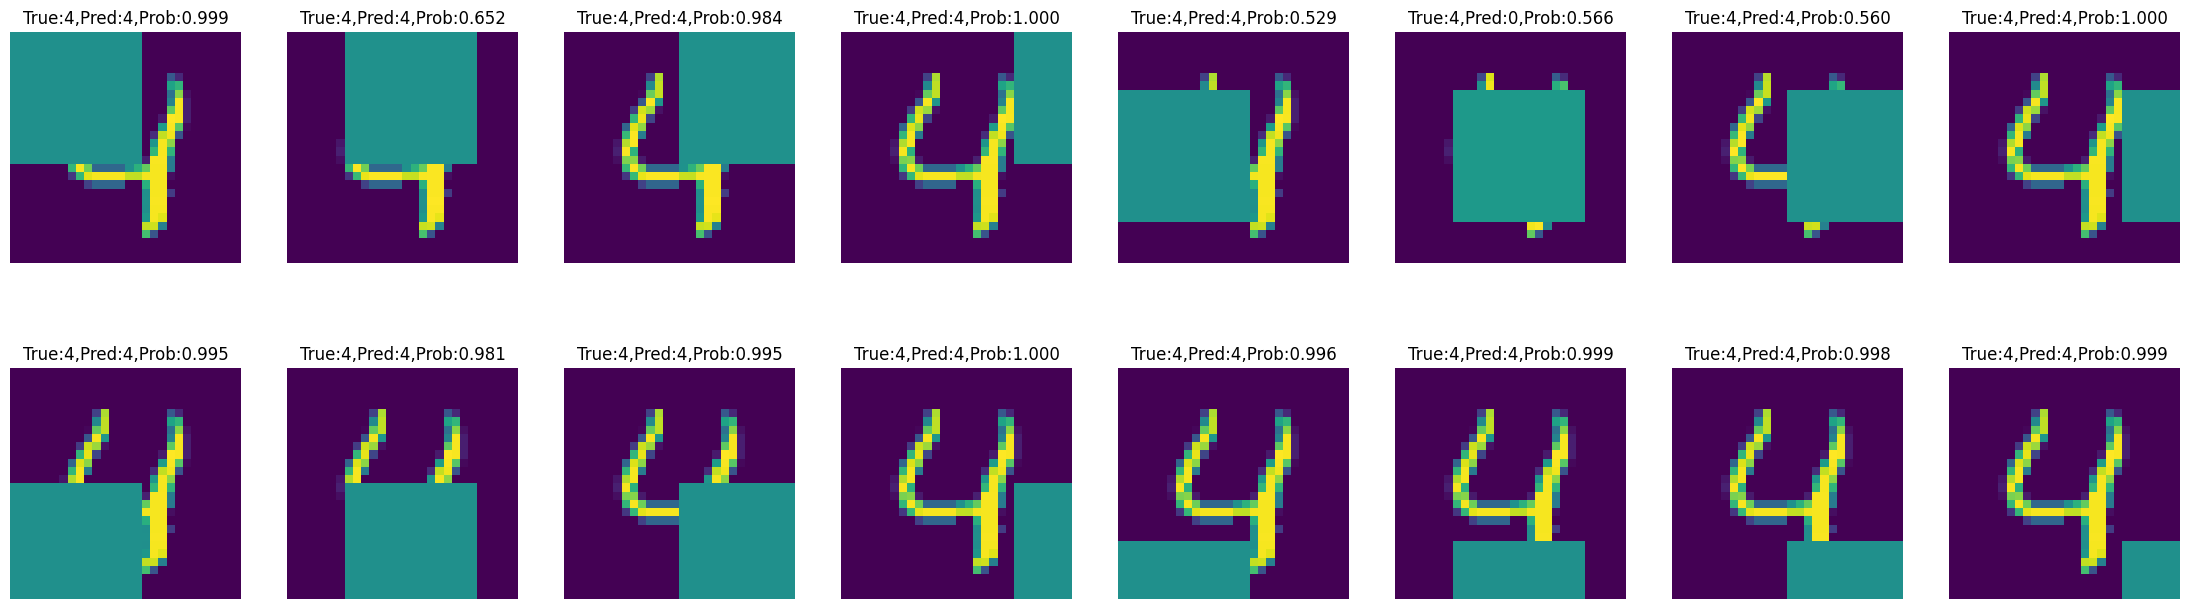

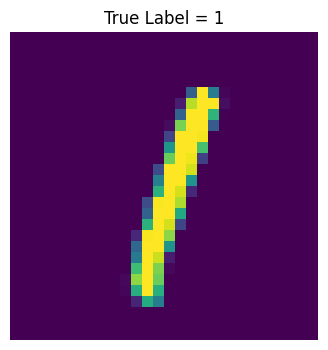

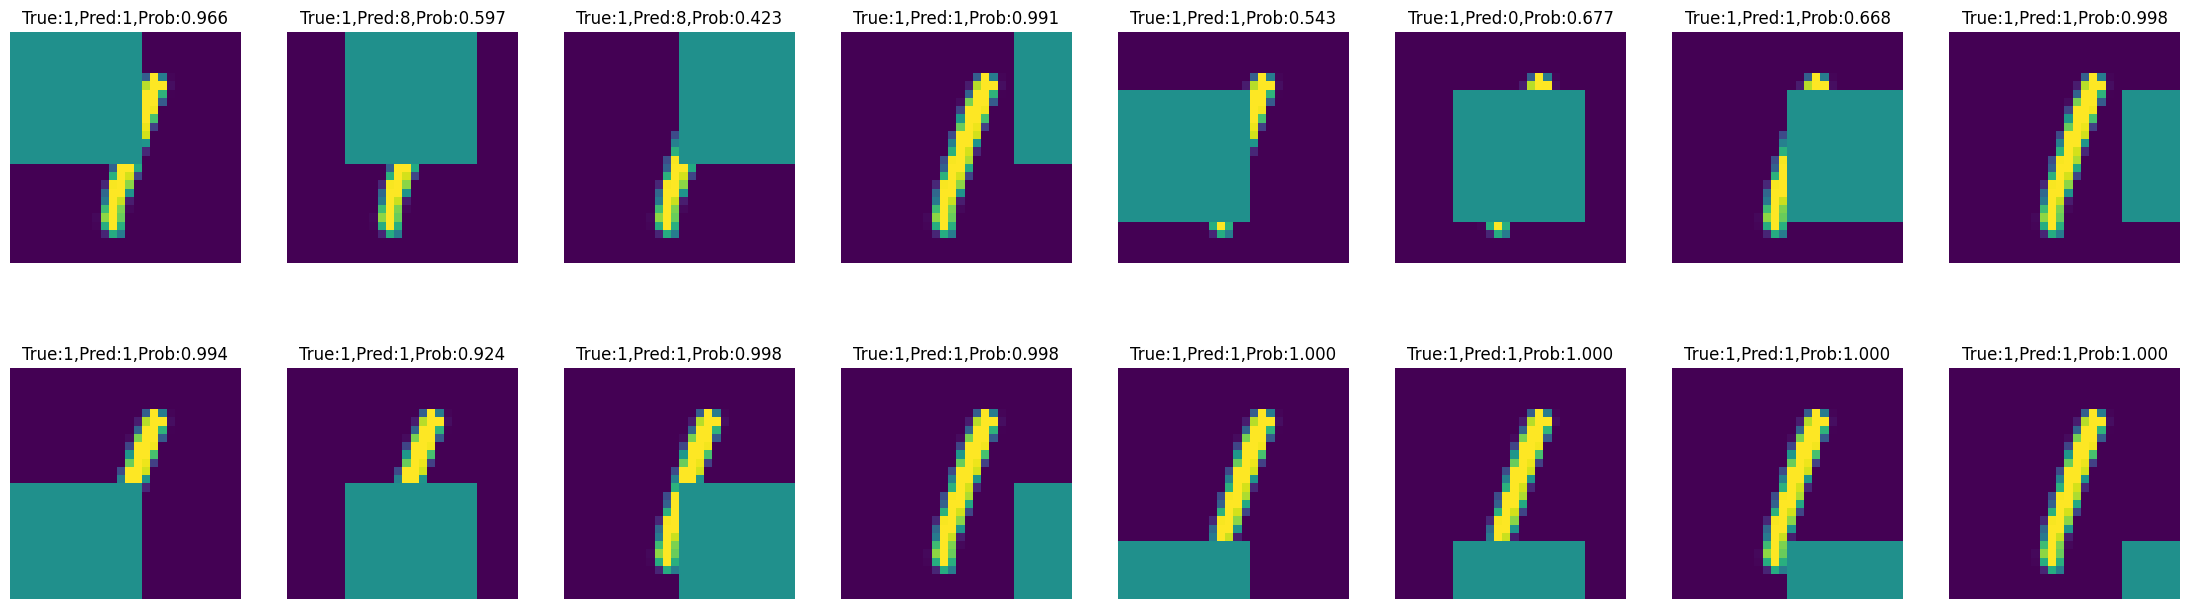

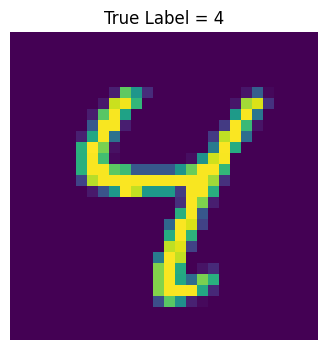

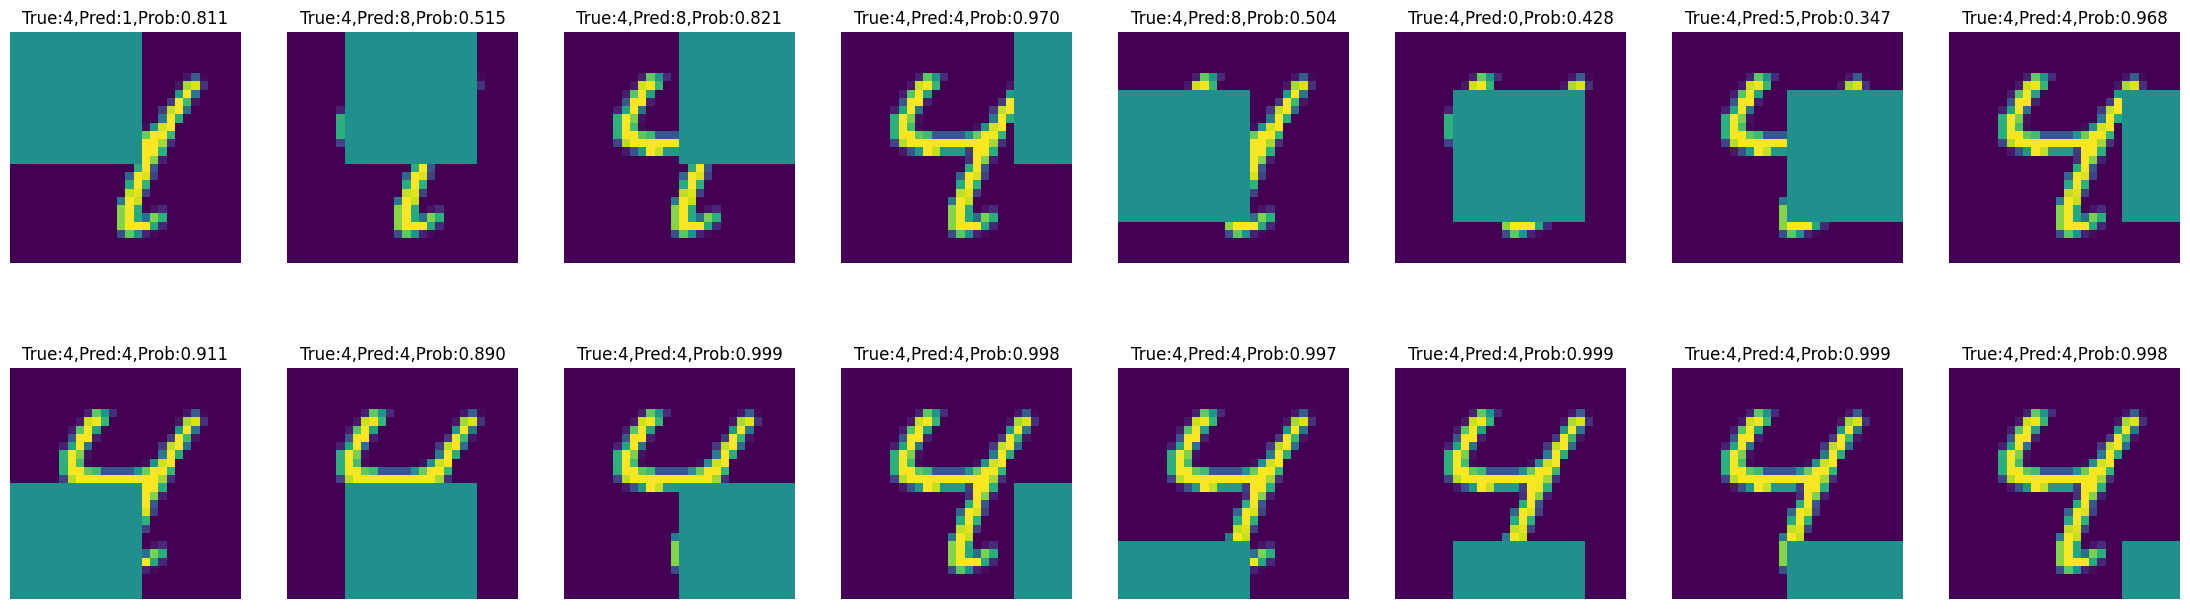

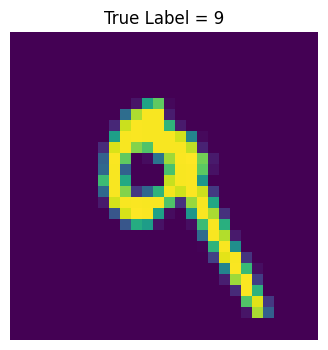

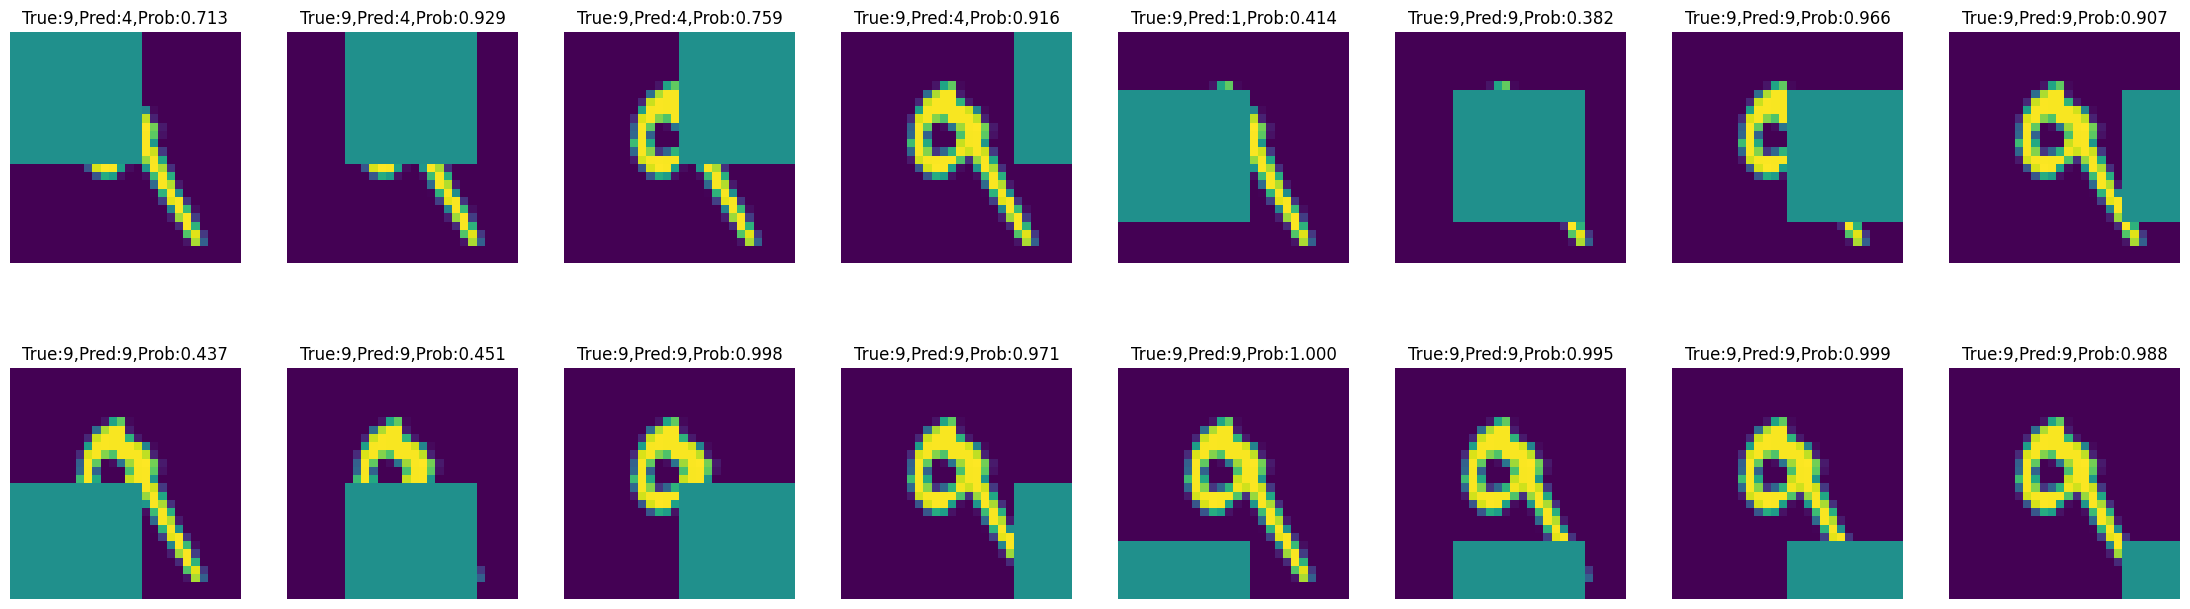

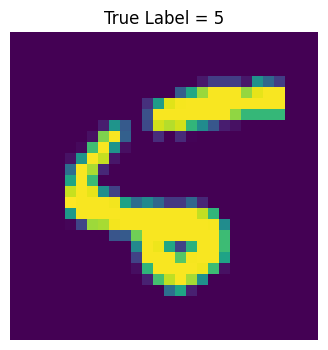

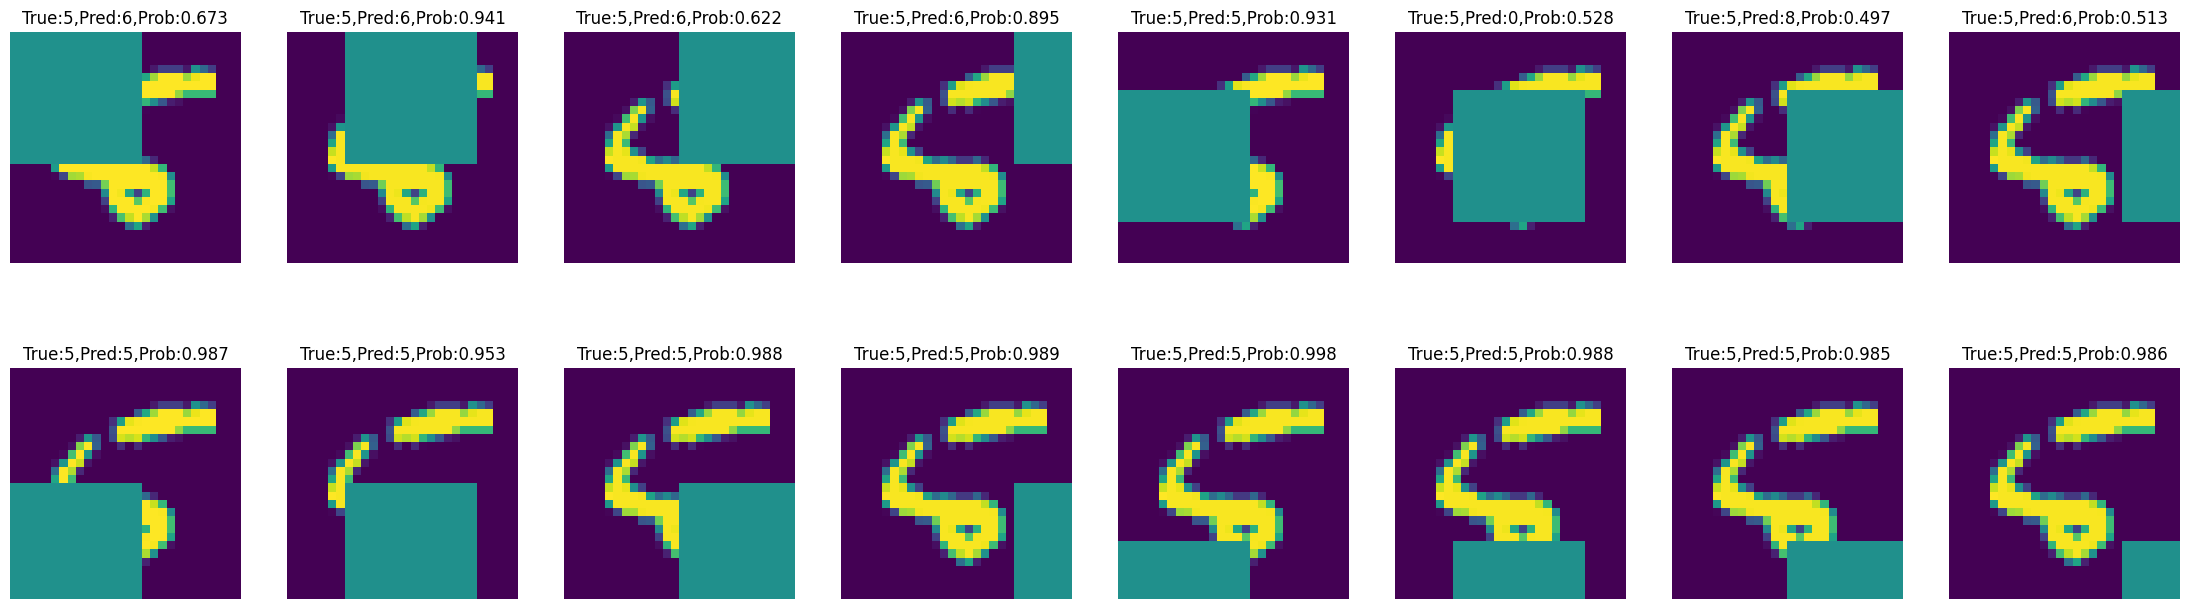

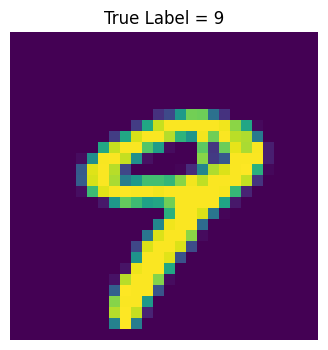

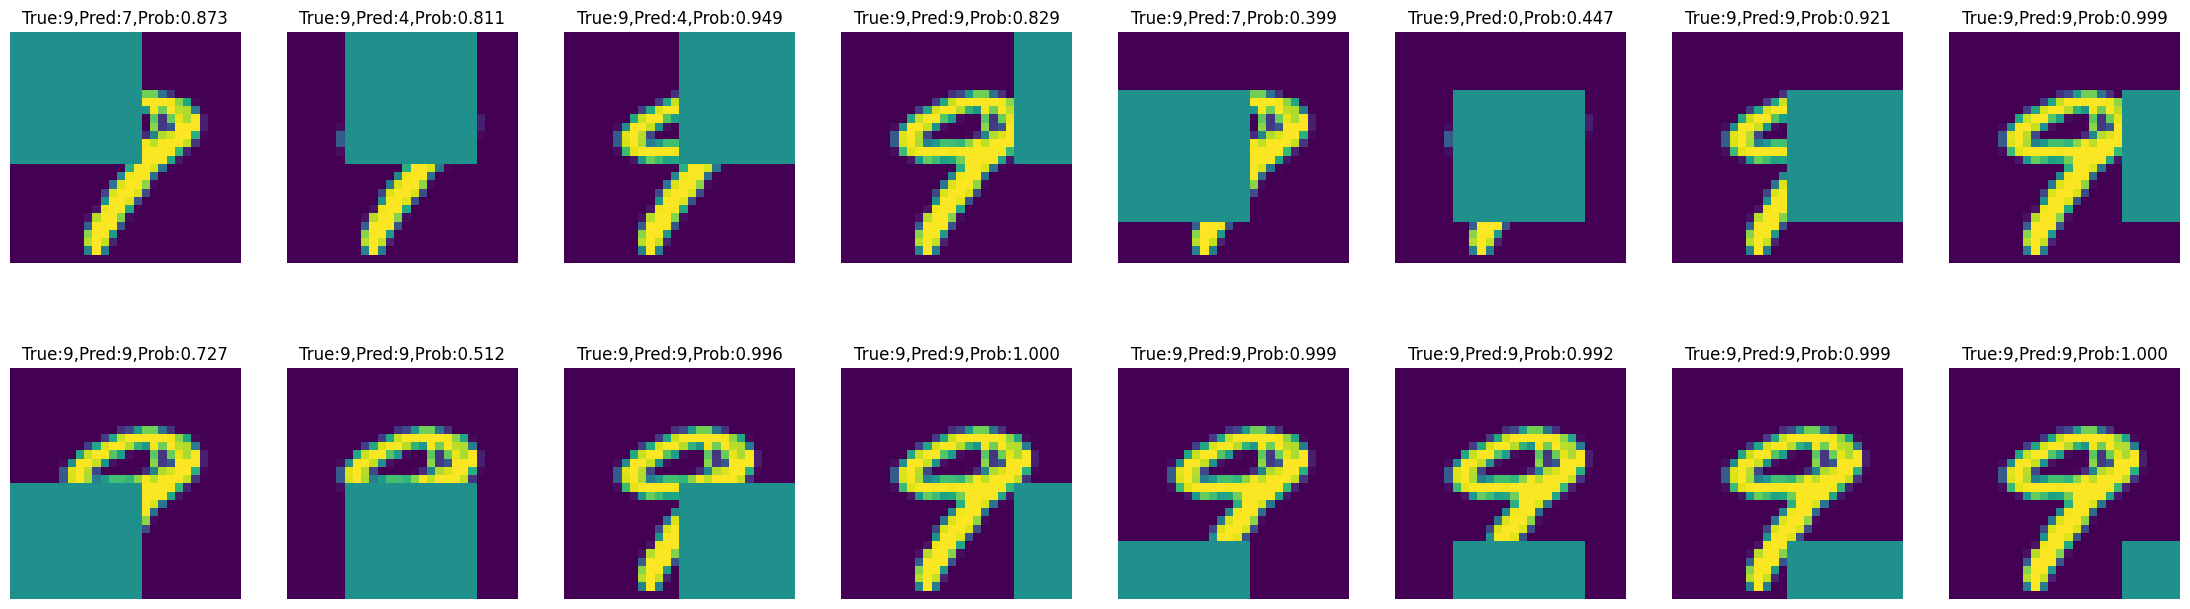

In [ ]:
for img,label in test_loader:
  img_10_g=img[:10].to(device)
  label_10_g=label[:10].to(device)
  for i in range(10):
    img_1_c=img_10_g[i].cpu().numpy().reshape(28,28)
    fig=plt.figure(figsize=(4,4))
    plt.axis("off")
    plt.title("True Label = "+str(np.squeeze(label.data.cpu().numpy())[i]))
    plt.imshow(img_1_c)
    plt.show()

    fig=plt.figure(figsize=(28,8))

    row,col=2,8
    loc=[]
    for x in range(0,27,7):
      for y in range(0,27,7):
        loc.append([x,y])
    
    for j in range(16):
      a=fig.add_subplot(row,col,j+1)
      occ_1_img=occluded_image(img_1_c,loc[j],16)
      plt.imshow(occ_1_img)
      plt.axis("off")

      img_1_torch = torch.from_numpy(occ_1_img.reshape(1,1,28,28))
      img_1_gpu = img_1_torch.to(device)
      prediction_vect_gpu = model(img_1_gpu)
      prediction_vect_cpu = prediction_vect_gpu.detach().cpu().numpy()
      prediction_vect_cpu=np.squeeze(prediction_vect_cpu)

      prediction_prob_vect=np.exp(prediction_vect_cpu)/np.sum(np.exp(prediction_vect_cpu))
      predicted_digit=np.argmax(prediction_prob_vect)
      prediction_probability=prediction_prob_vect[predicted_digit]
      a.set_title('True:{},Pred:{},Prob:{:.3f}'.format(label.data[i],predicted_digit,prediction_probability))

    plt.show()
 

<font color='green'>As can be seen from above results, As we occlude the digit image, the probability of the actual prediction image drops, and sometimes the model prediction goes wrong, which shows that our model is actually looking at the meaningful features for digit classification.

# **NON TARGETED ATTACK**

In [ ]:
for child in model.children():
  for param in child.parameters():
    param.requires_grad = False

In [ ]:
img_grid = np.zeros((10,28,28))
cost={}
for i in range(10):
  noise = np.random.normal(loc=0.5,scale=0.05,size=(1,1,28,28)).astype(np.float32)
  noise = torch.from_numpy(noise)
  x_var = torch.tensor(noise.type(torch.cuda.FloatTensor),requires_grad=True, device='cuda')
  optimizer = torch.optim.SGD([x_var],lr=0.0001)
  cost[str(i)]=[]
  for j in range(3000):
    model.zero_grad()
    out_var=model(x_var)
    loss=-out_var[0][i]
    loss.backward()
    optimizer.step()

    
    cost[str(i)].append(loss.item())
   
  n_img = x_var.cpu().detach().numpy()
  img_grid[i,:,:] = normalize(n_img)

/tmp/ipykernel_984428/1069001644.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(noise.type(torch.cuda.FloatTensor),requires_grad=True, device='cuda')


1. Show the generated image for each of the MNIST classes.

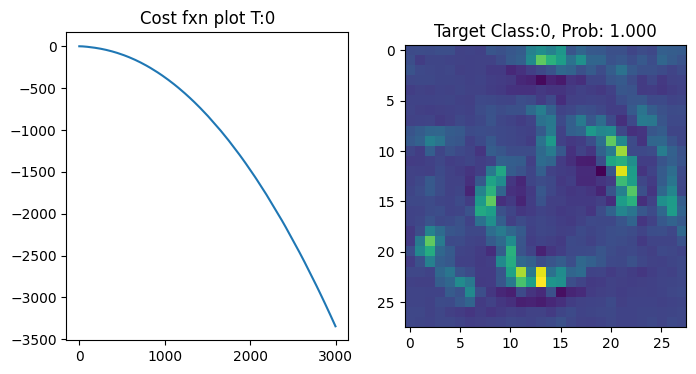

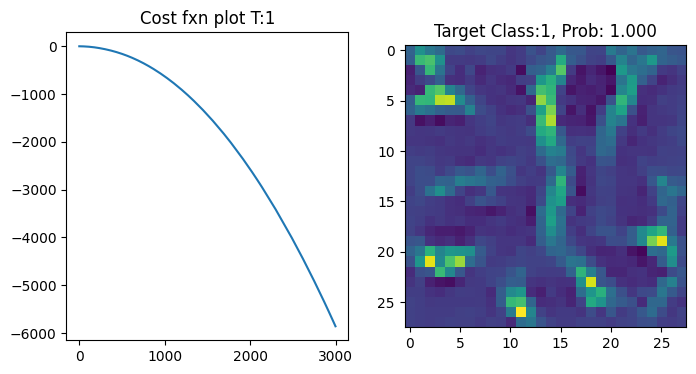

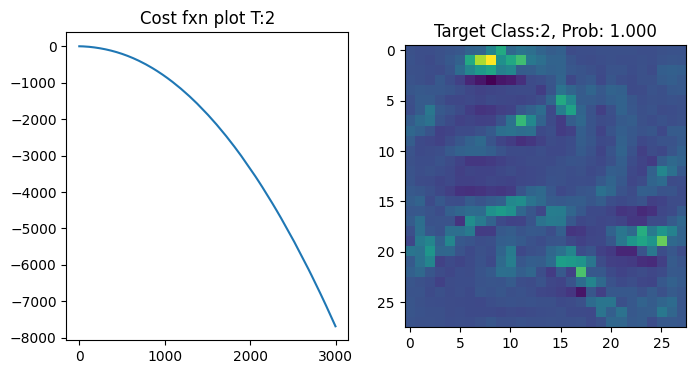

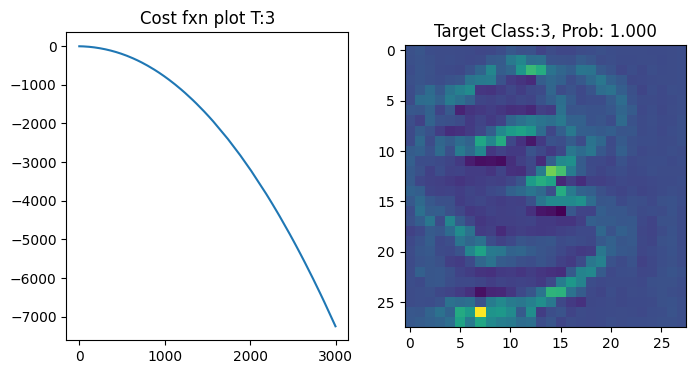

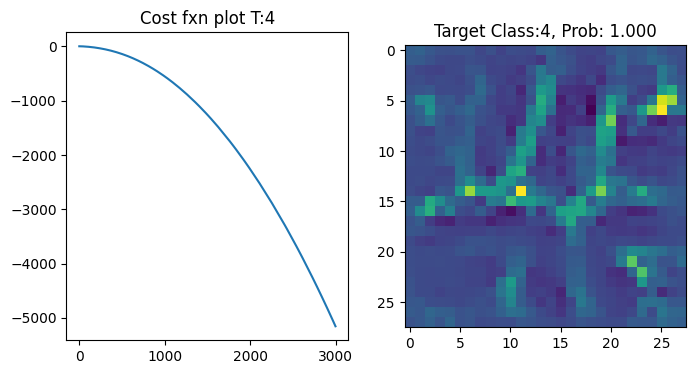

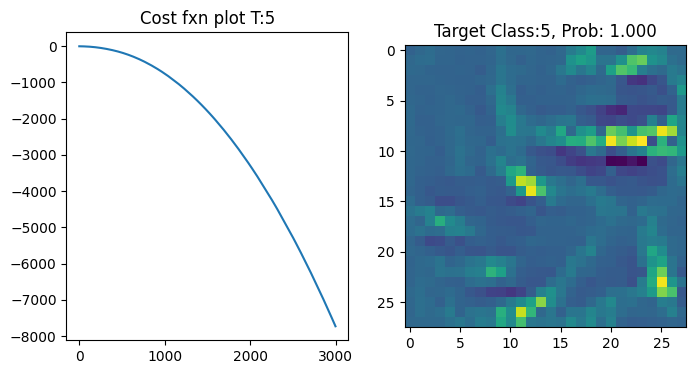

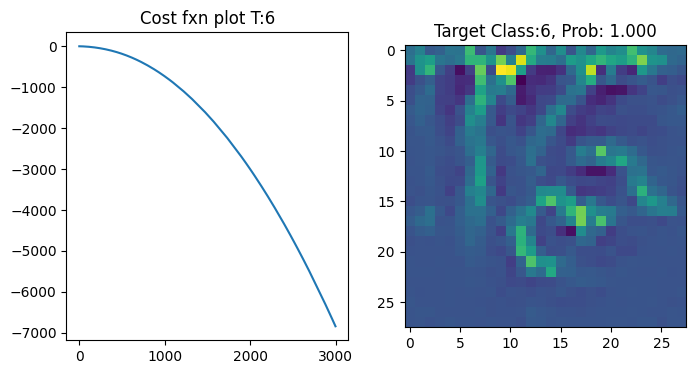

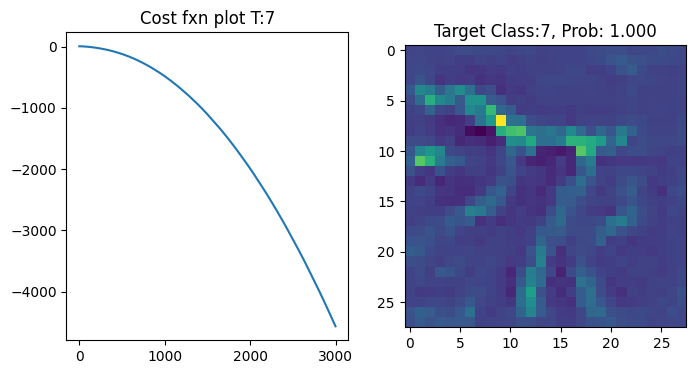

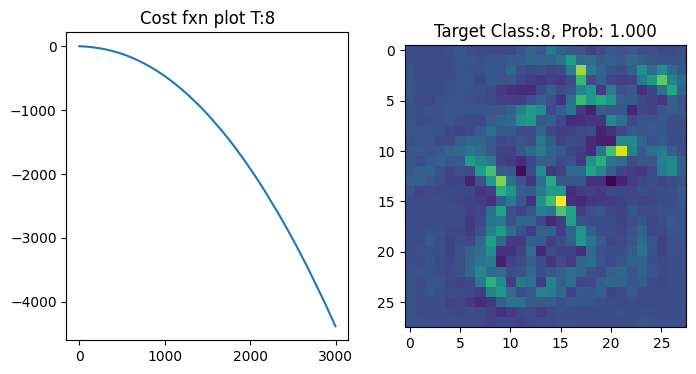

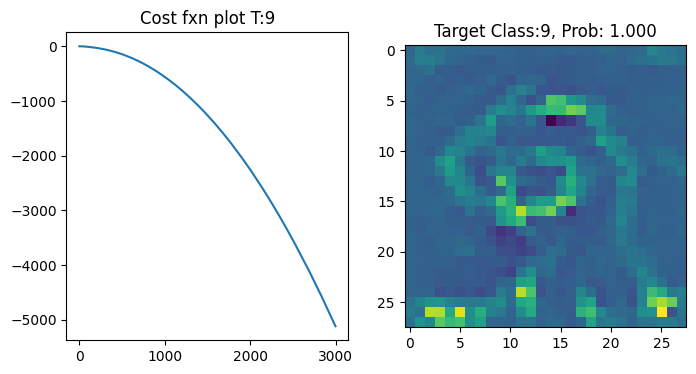

In [ ]:
for i in range(10):
  
  fig = plt.figure(figsize=(8,4))
  fig.tight_layout()
  col,row = 2,1
  
  in_image=torch.reshape(torch.from_numpy(img_grid[i].astype(np.float32)),(1,1,28,28)).to(device)
#   print(in_image.size)
  prediction_vect_gpu=model(in_image)
  prediction_vect_cpu = prediction_vect_gpu.detach().cpu().numpy()
  prediction_vect_cpu=np.squeeze(prediction_vect_cpu)-np.max(prediction_vect_cpu) ##subtracting max value from each entry to avoid overflow in exponential.

  prediction_prob_vect=np.exp(prediction_vect_cpu)/np.sum(np.exp(prediction_vect_cpu))
  predicted_digit=np.argmax(prediction_prob_vect)
  prediction_probability=prediction_prob_vect[predicted_digit]


  a = fig.add_subplot(row,col,1 )
  a.title.set_text('Cost fxn plot T:{}'.format(i))
  a.plot(np.arange(0,len(cost[str(i)])),np.array(cost[str(i)]))

  b= fig.add_subplot(row,col,2)
  b.title.set_text('Target Class:{}, Prob: {:.3f}'.format(predicted_digit,prediction_probability))
  plt.imshow(img_grid[i])

plt.show()

2. Is the network always predicting targetClass with high confidence for the generated images? 

<font color='green'> **Yes** </font>

3. Do the generated images look like a number? If not, can you think of some reason? 

<font color='green'> **No**, Because we are generating images in accordance with how our model looks at images to classify them. So, even though the model classifys it as a digit but the image makes no sense to a human. </font>

4. Plot the cost function. Is it increasing or decreasing?

<font color='green'>  As I am increasing the probability of the classification of the digit, I am using a loss function to be negative as that given in assignment, Since our optimizers always minimises the cost. So for my case, The cost function is **decreasing**. As per the cost function given in the assignment it would be negative of this plot i.e. 'increasing'</font>

Identifying a Test Image set which contains all classes for proper testing

In [ ]:
for images,labels in test_loader:
    print(torch.unique(labels[9705:9715]))
    for k in range(9705,9715):
        print(k, labels[k])

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
9705 tensor(1)
9706 tensor(2)
9707 tensor(3)
9708 tensor(4)
9709 tensor(5)
9710 tensor(6)
9711 tensor(7)
9712 tensor(8)
9713 tensor(9)
9714 tensor(0)


# **TARGETED ATTACK**

1. Show the generated image for each of the MNIST classes. Do the generated images now look like a number?

<font color='green'>The below cell output shows the generated images for each of classes being falsely classified as all the classes. **Yes**, now the images look like a digit.</font>

/tmp/ipykernel_984428/2746526485.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_var=torch.tensor(img_.type(torch.cuda.FloatTensor),requires_grad=True,device='cuda')


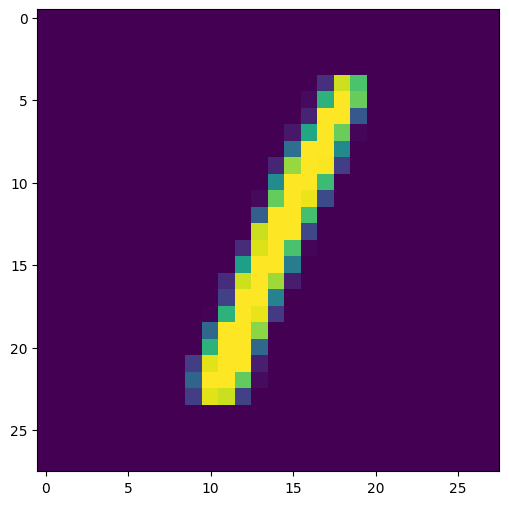

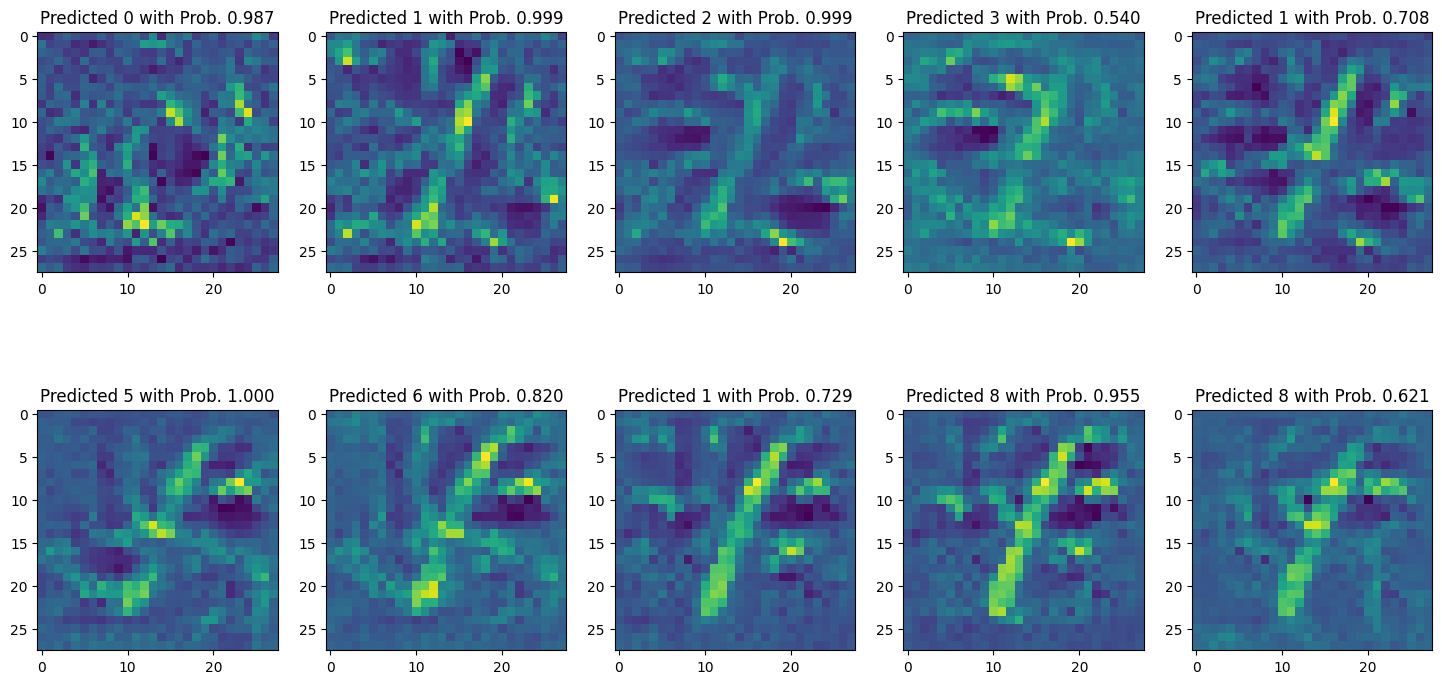

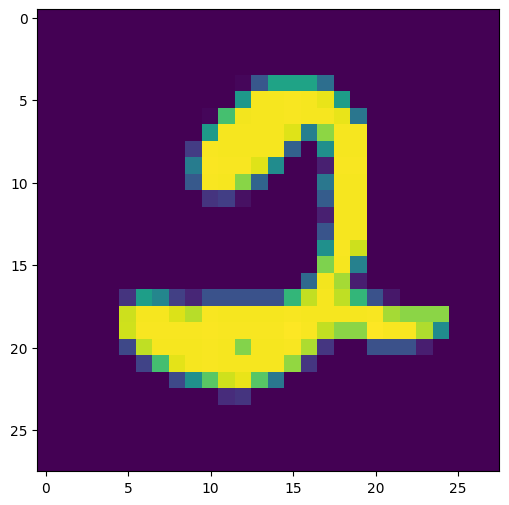

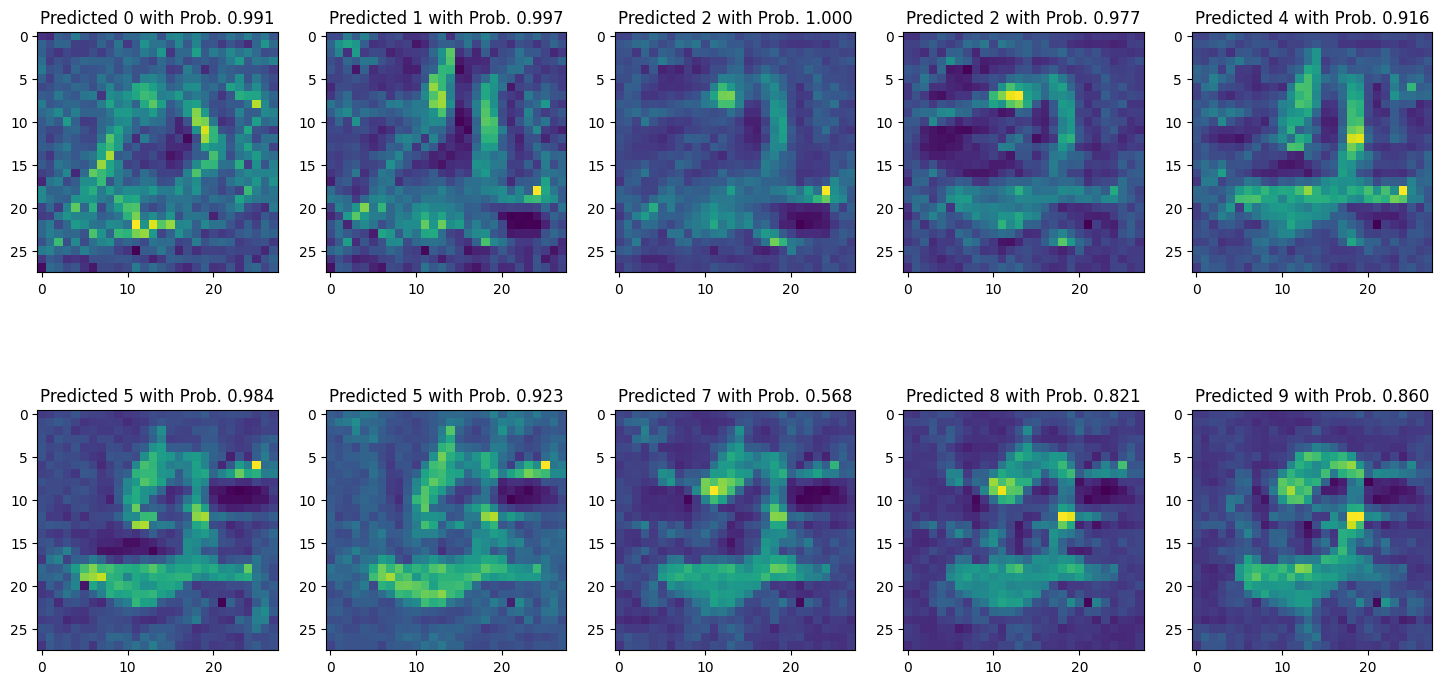

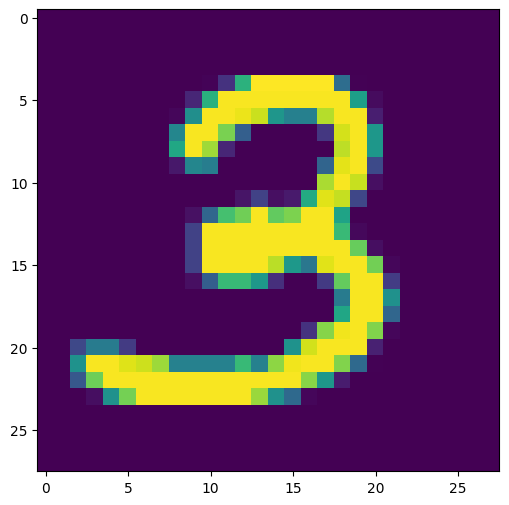

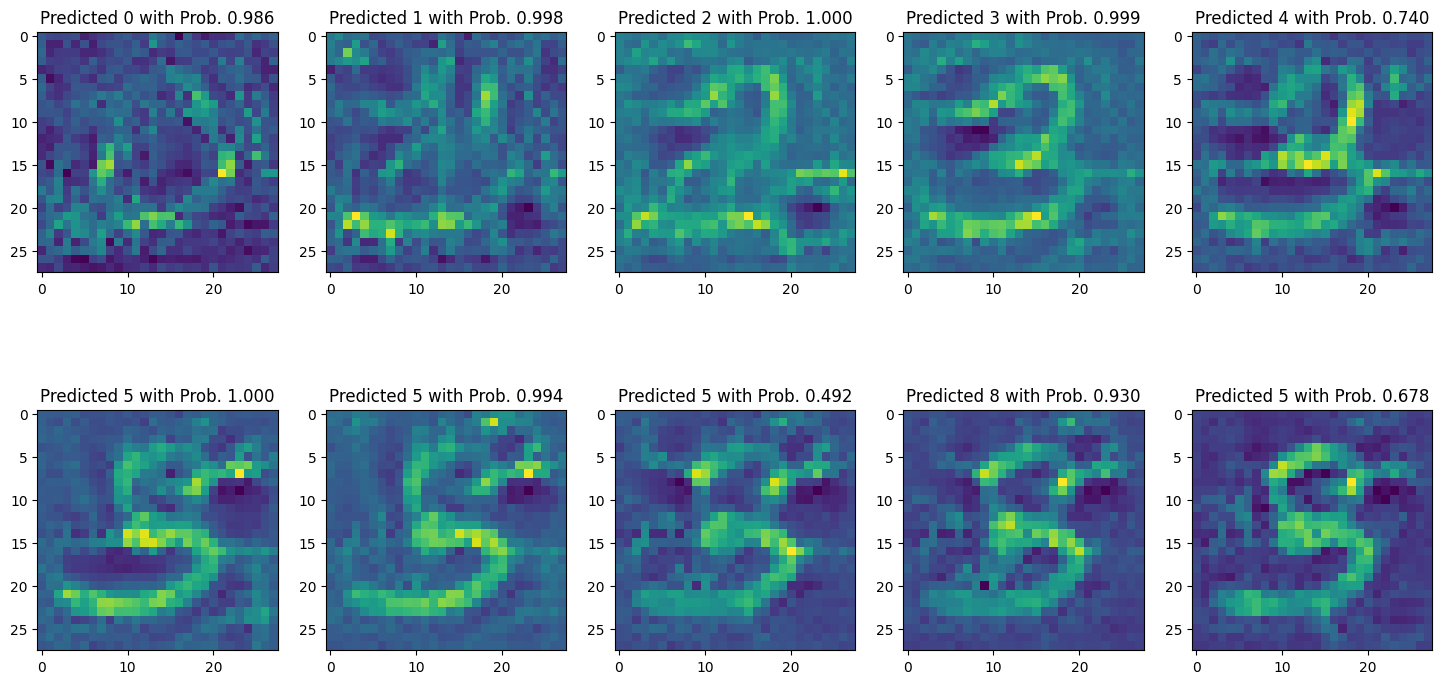

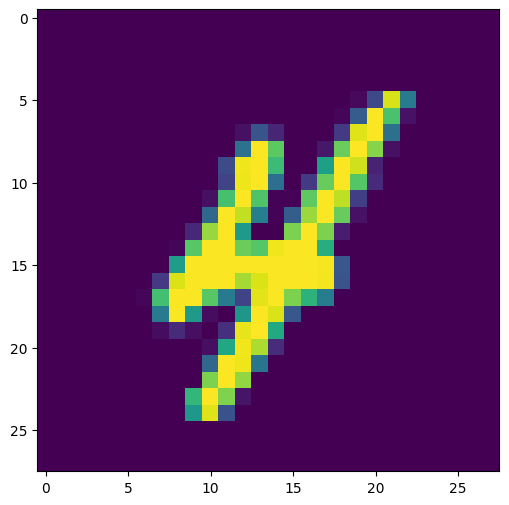

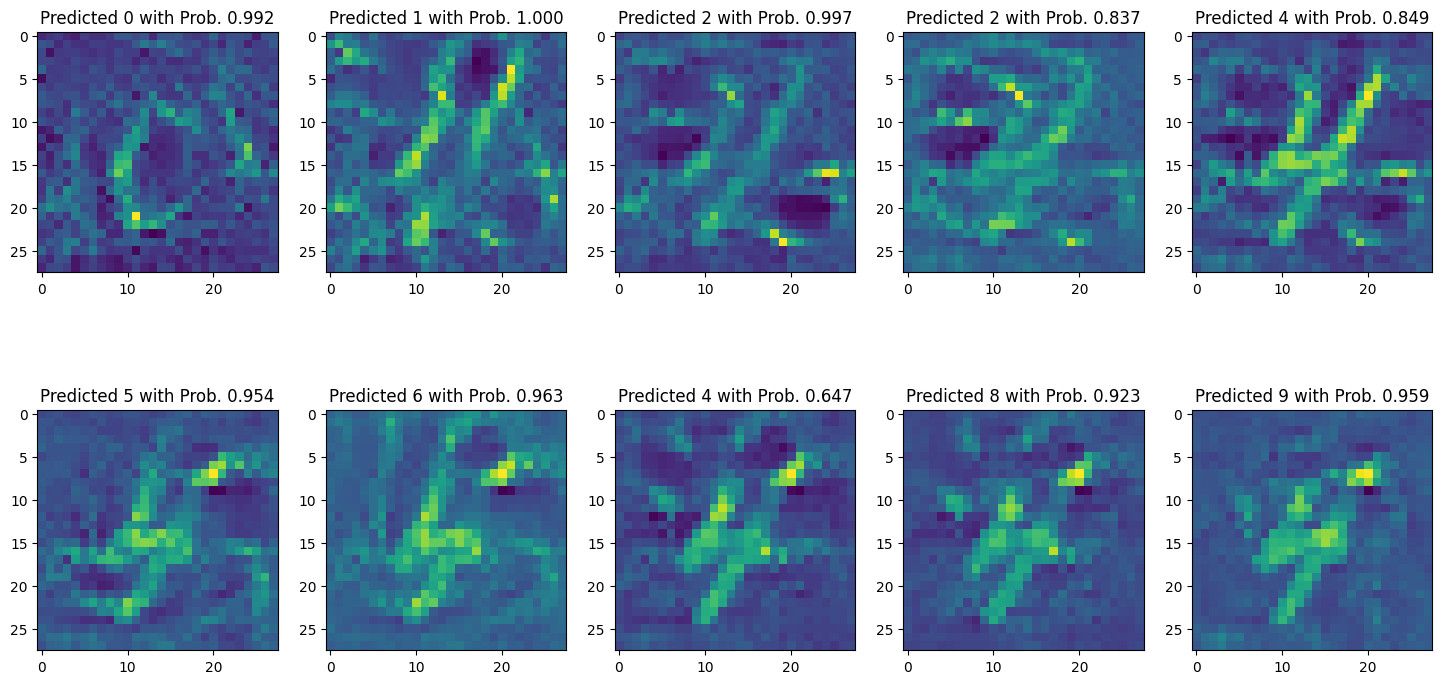

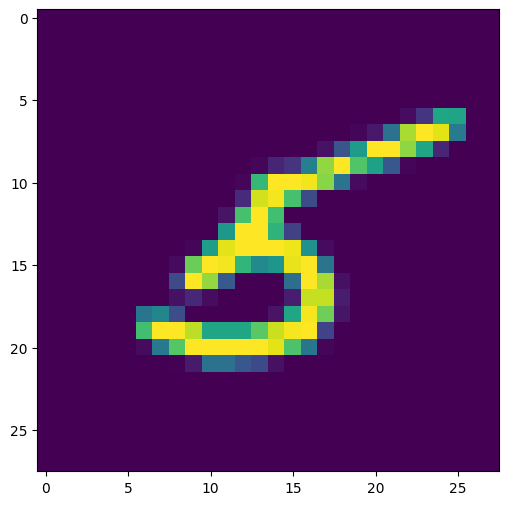

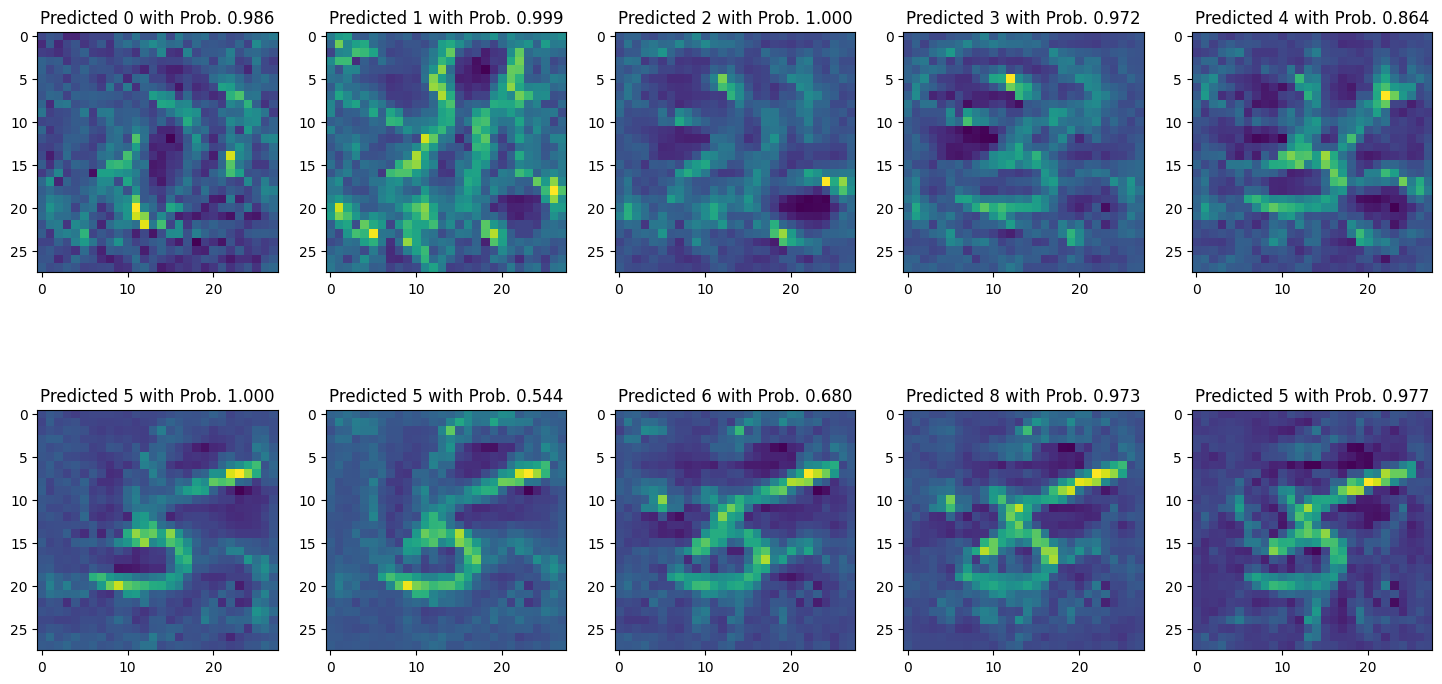

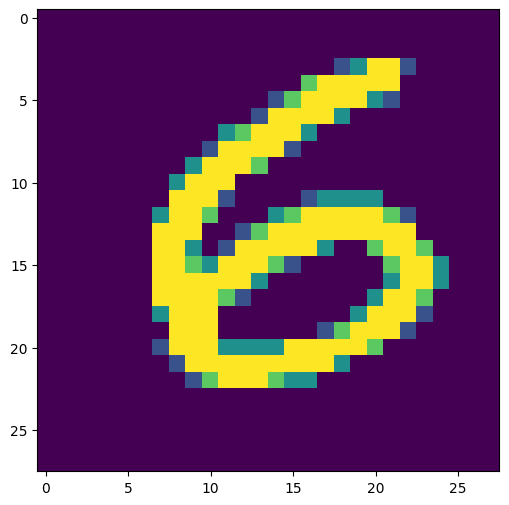

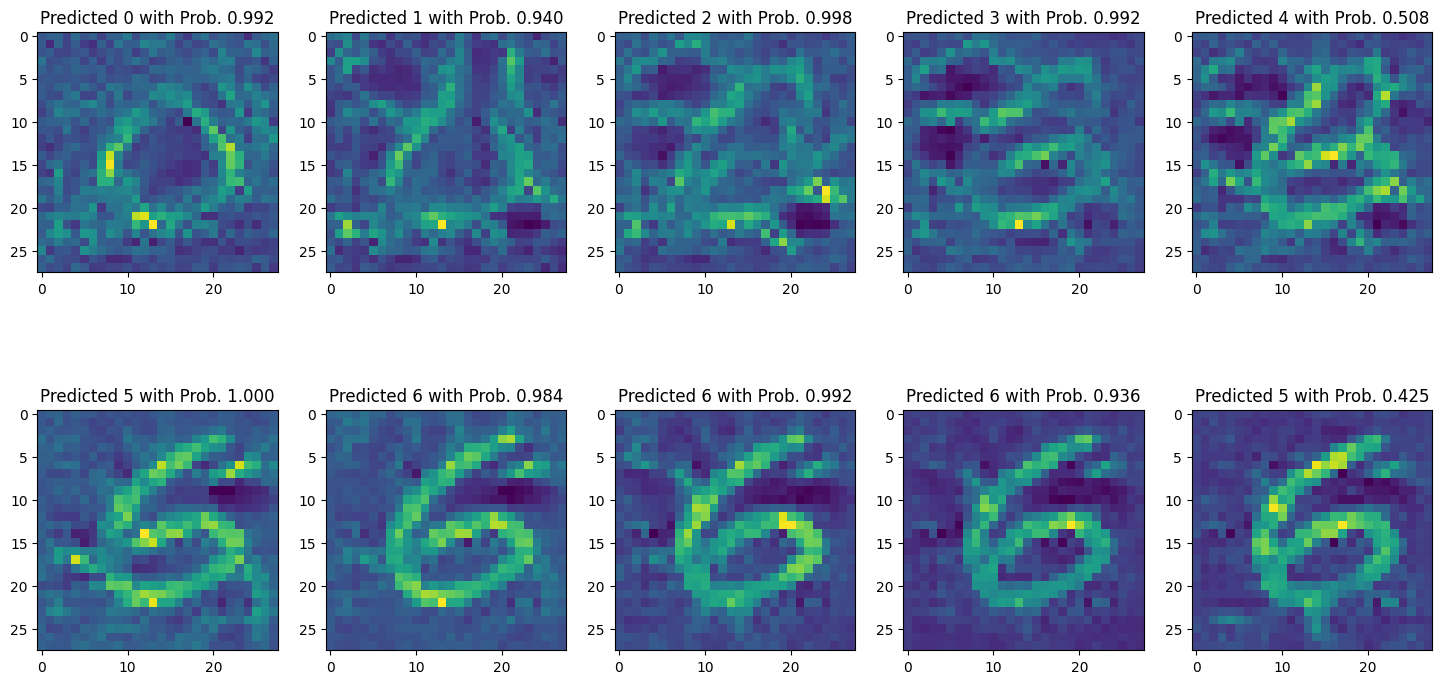

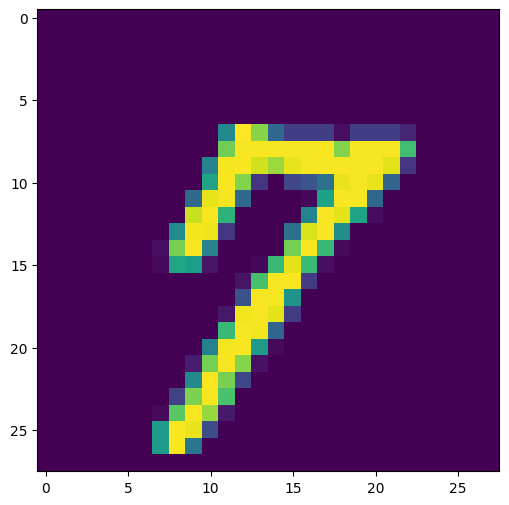

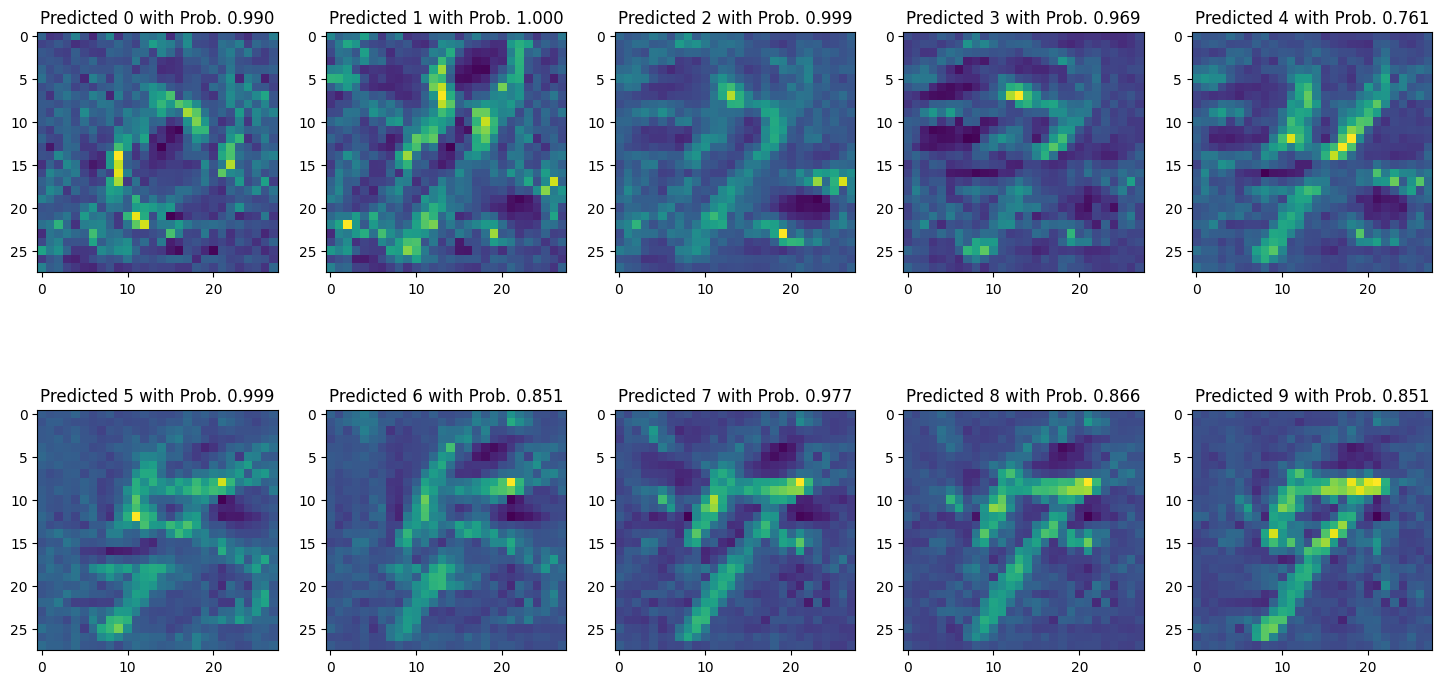

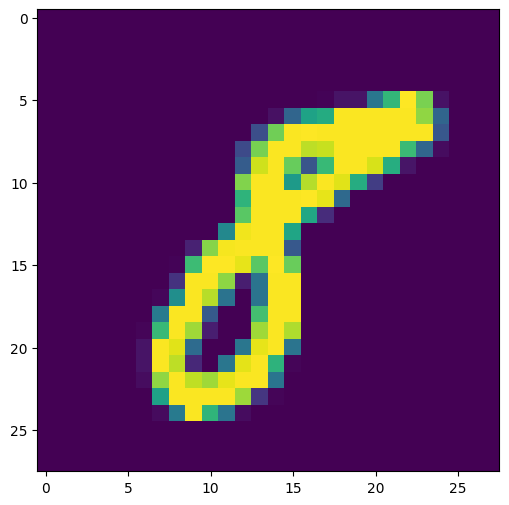

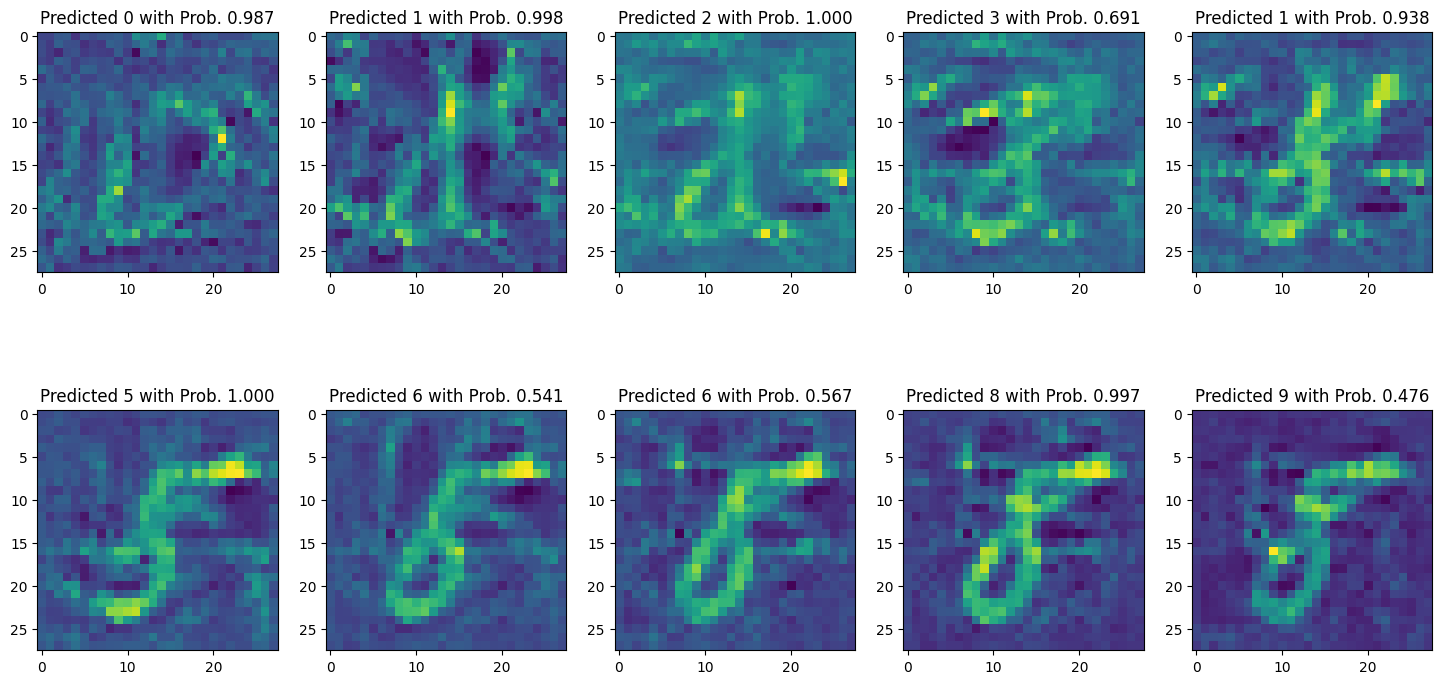

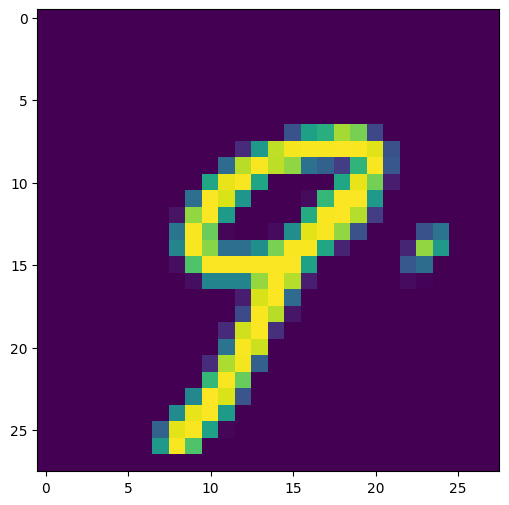

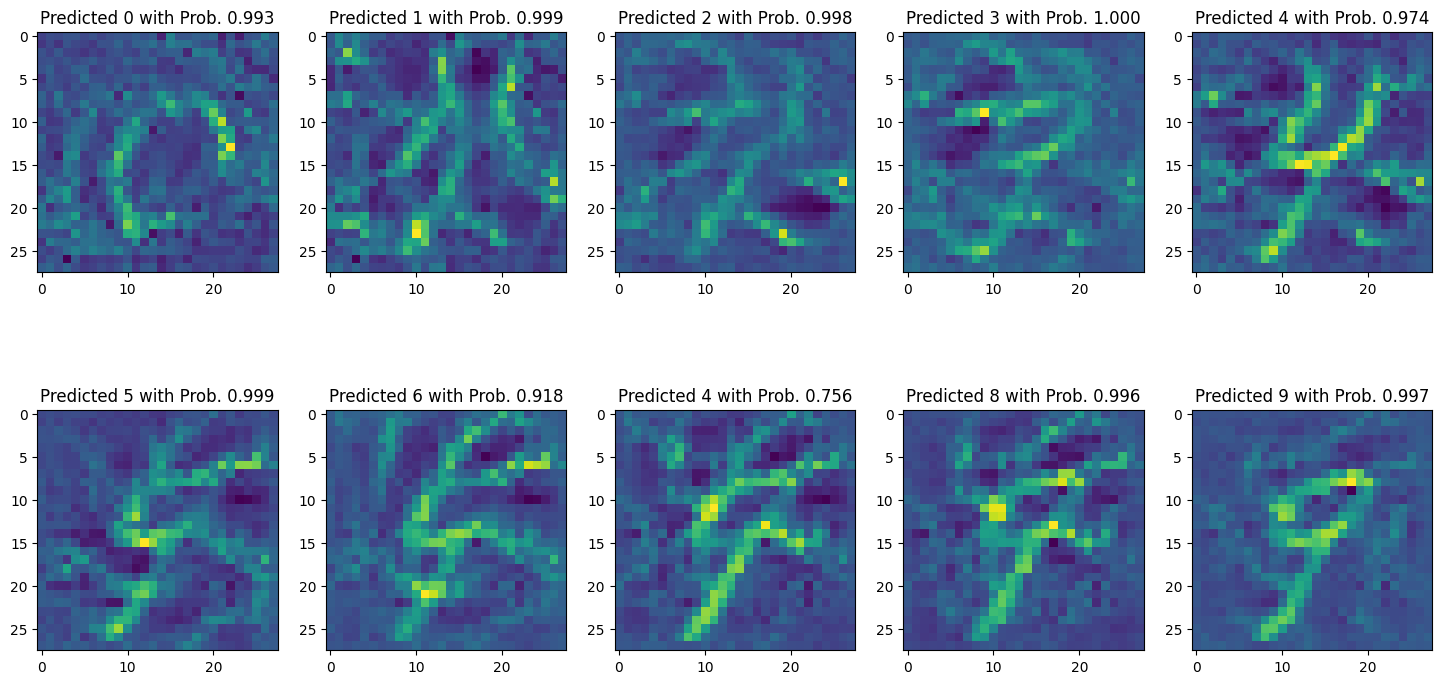

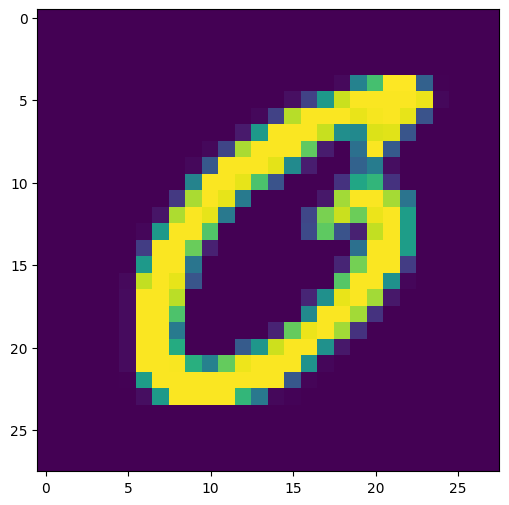

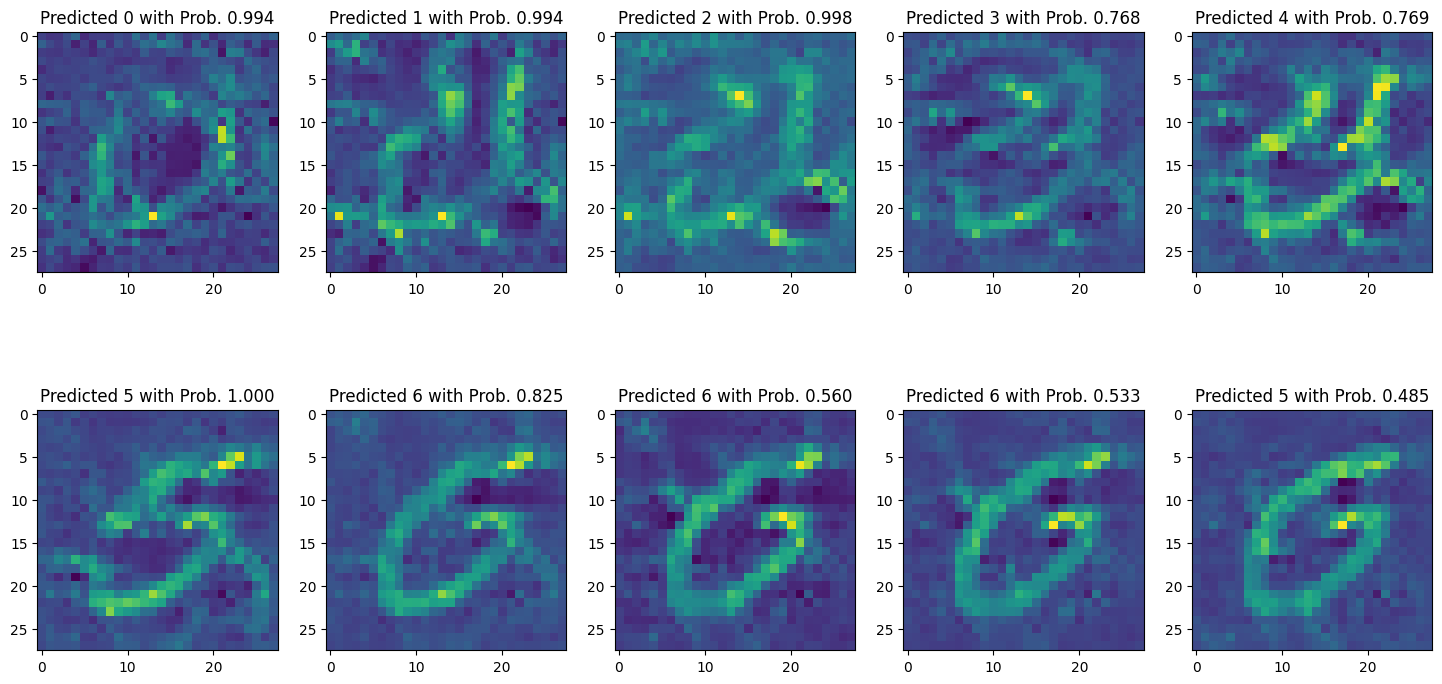

In [ ]:
for images,labels in test_loader:   
    for k in range(9705,9715):
        
        beta=70

        col,row = 5,2
        target_img=images[k].to(device)
        fig = plt.figure(figsize=(6,6))
        plt.imshow(torch.squeeze(images[k]).cpu().numpy())

        fig = plt.figure(figsize=(18,9))
        fig.tight_layout()

        img_= np.random.normal(loc=0.5,scale=0.05,size=(1,1,28,28)).astype(np.float32)
        img_=torch.from_numpy(img_)
        img_=img_.to(device)
        img_var=torch.tensor(img_.type(torch.cuda.FloatTensor),requires_grad=True,device='cuda')
        optimizer=torch.optim.SGD([img_var],lr=0.0001)
        for target_label in range(10):
            for j in range(5000):
                optimizer.zero_grad()
                out_var=model(img_var)
                mse_loss=nn.MSELoss()

                loss=-1*out_var[0][target_label]+beta*mse_loss(img_var,target_img)
                loss.backward()
                optimizer.step()

            img_var_cpu=img_var.cpu().detach().numpy()
            img_var_cpu_normalized=normalize(img_var_cpu)


            prediction_vect_gpu=model(img_var)
            prediction_vect_cpu = prediction_vect_gpu.detach().cpu().numpy()
            prediction_vect_cpu=np.squeeze(prediction_vect_cpu)

            prediction_prob_vect=np.exp(prediction_vect_cpu)/np.sum(np.exp(prediction_vect_cpu))
            predicted_digit=np.argmax(prediction_prob_vect)
            prediction_probability=prediction_prob_vect[predicted_digit]

            a= fig.add_subplot(row,col,target_label+1)
            a.title.set_text('Predicted {} with Prob. {:.3f}'.format(predicted_digit,prediction_probability))
            plt.imshow(np.squeeze(img_var_cpu_normalized))

# **ADDITION OF NOISE**

1. Show the generated adversarial image, and the noise for each of the classes of MNIST.
2. Sample a fixed set of 10 test examples from the dataset. Add the adversarial noise and classify. Show the true class and the predicted class. Repeat this for all the 10 generated adversarial noise matrices.

<font color='green'> The cell output below contains the noise for each of the classes. Furthermore, a test set of 10 images have been added with these noises and have been misclassified with higer probability as the target classes. Hence the model has been successfully fooled by addition of these noises.</font>

TARGET CLASS: 0


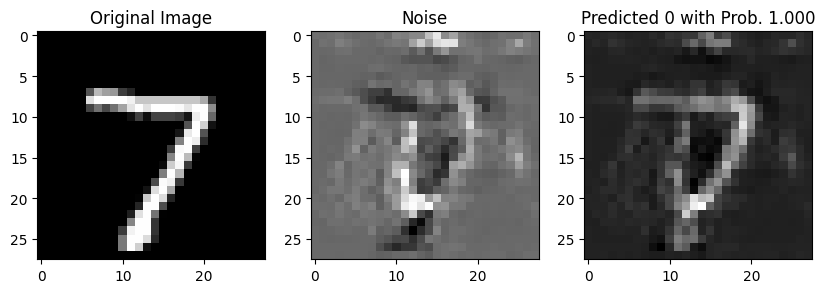

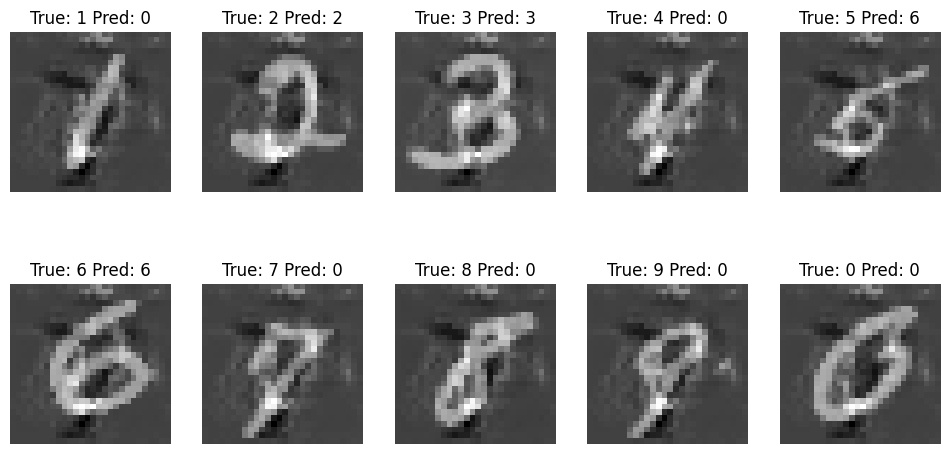

TARGET CLASS: 1


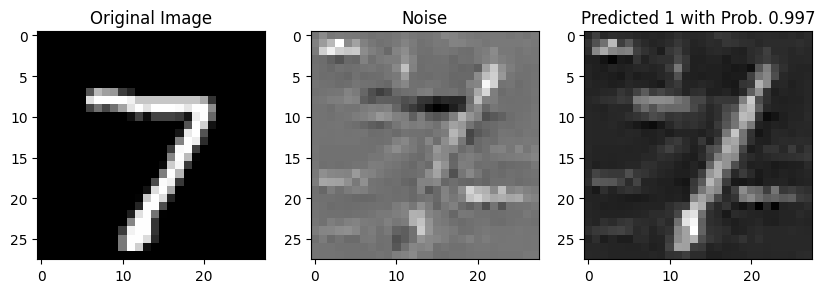

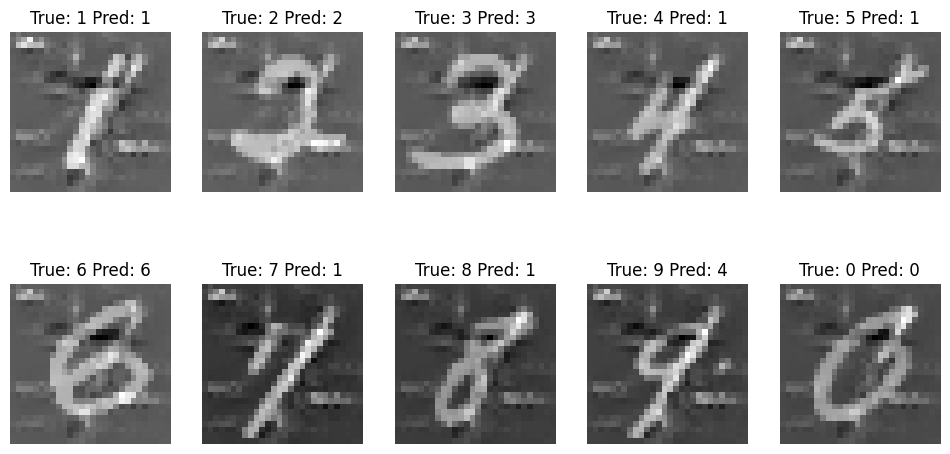

TARGET CLASS: 2


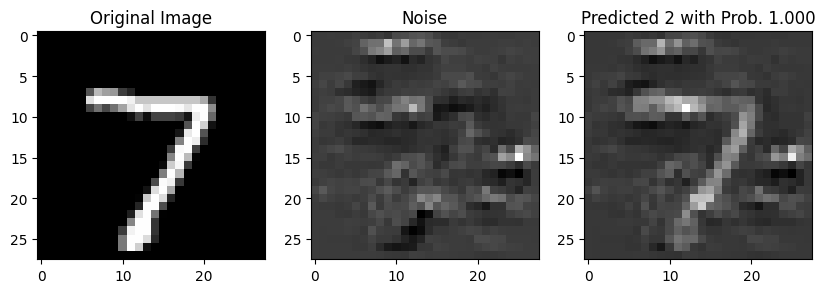

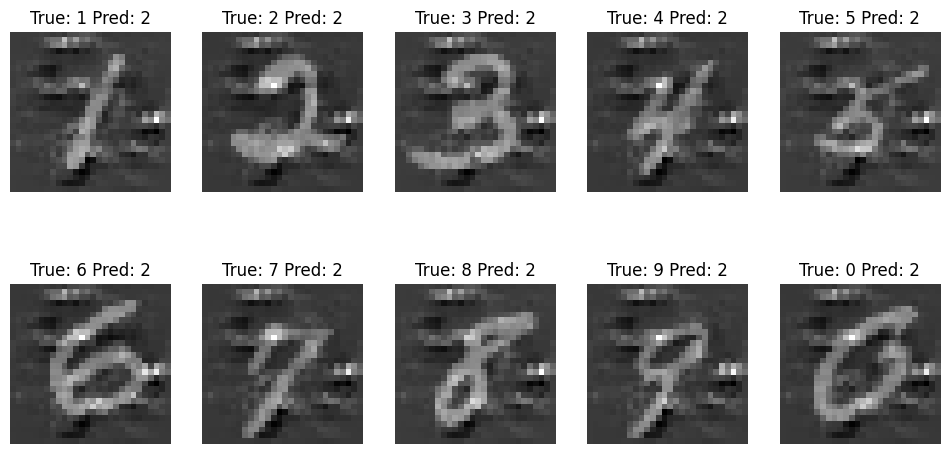

TARGET CLASS: 3


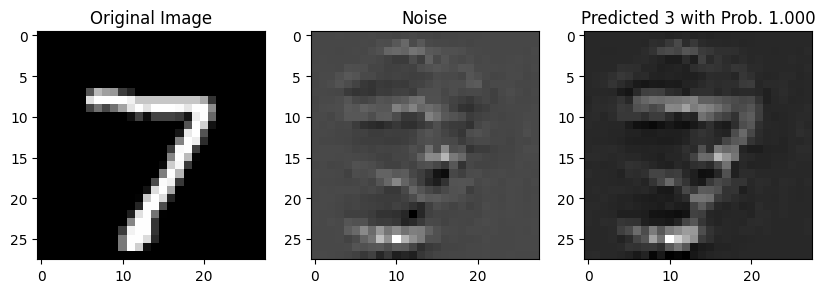

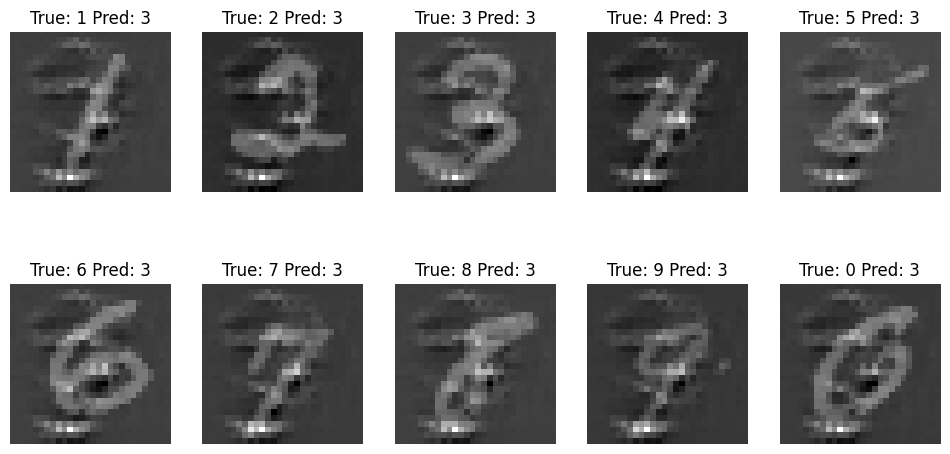

TARGET CLASS: 4


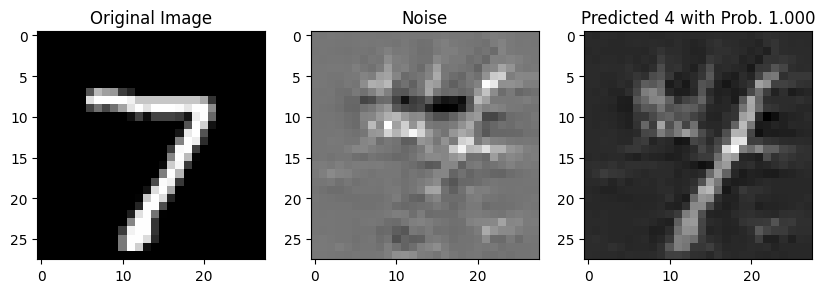

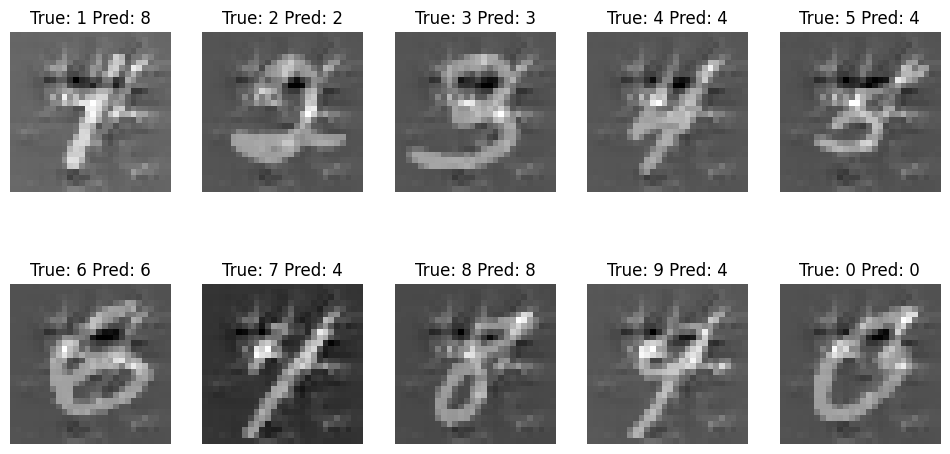

TARGET CLASS: 5


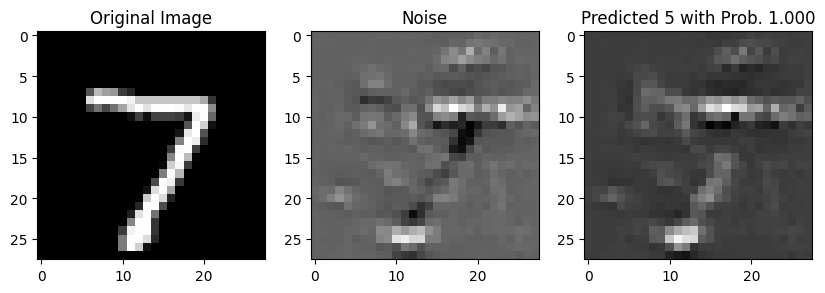

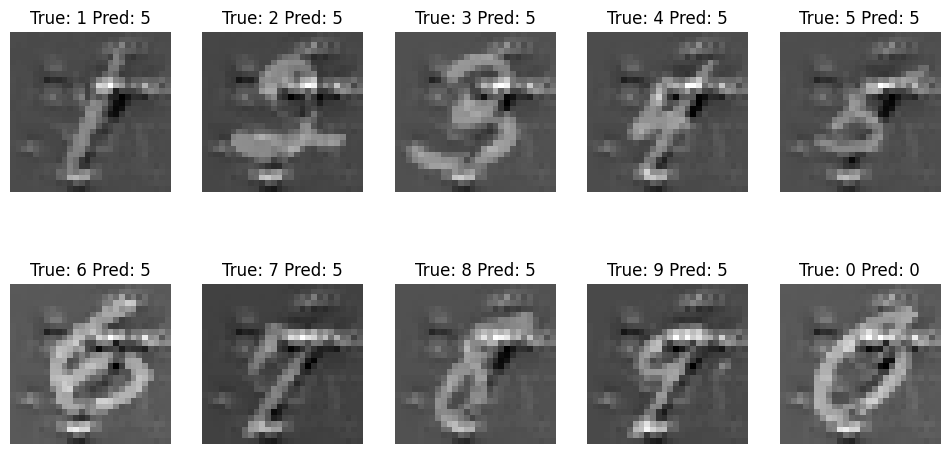

TARGET CLASS: 6


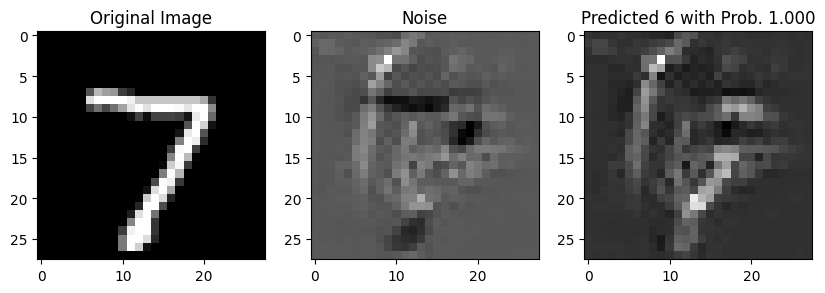

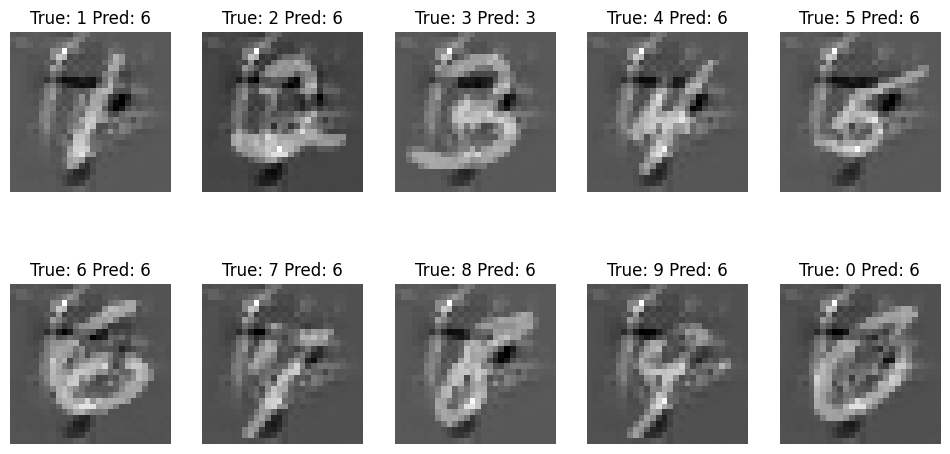

TARGET CLASS: 7


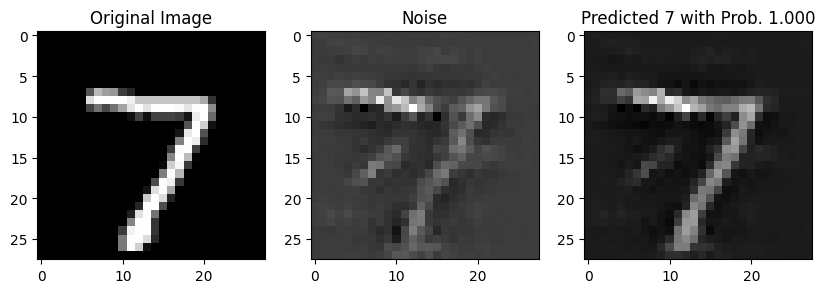

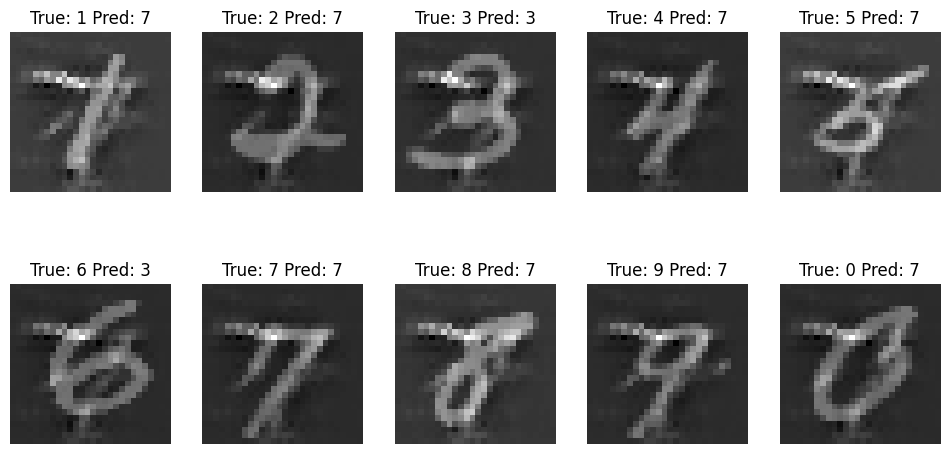

TARGET CLASS: 8


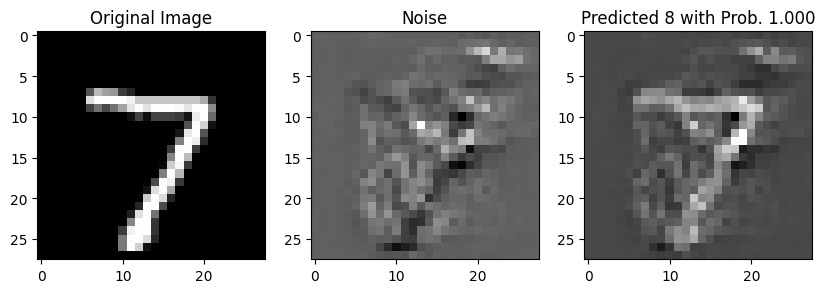

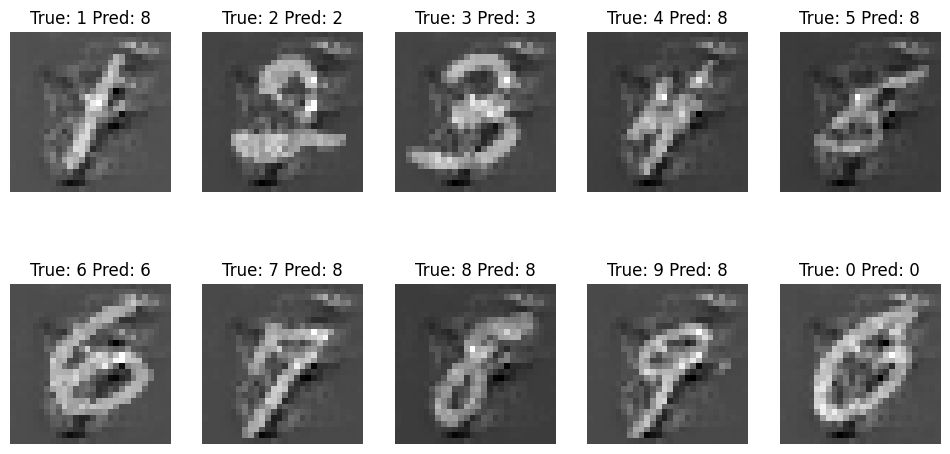

TARGET CLASS: 9


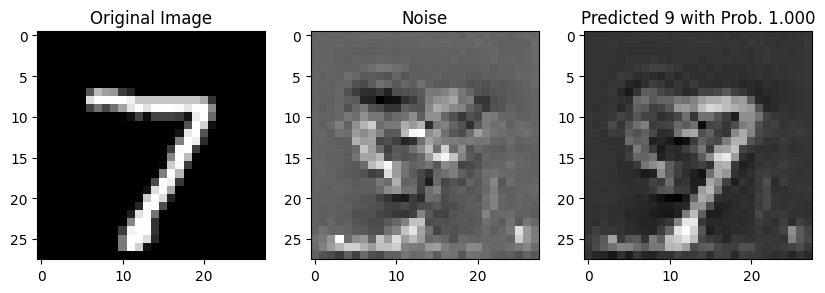

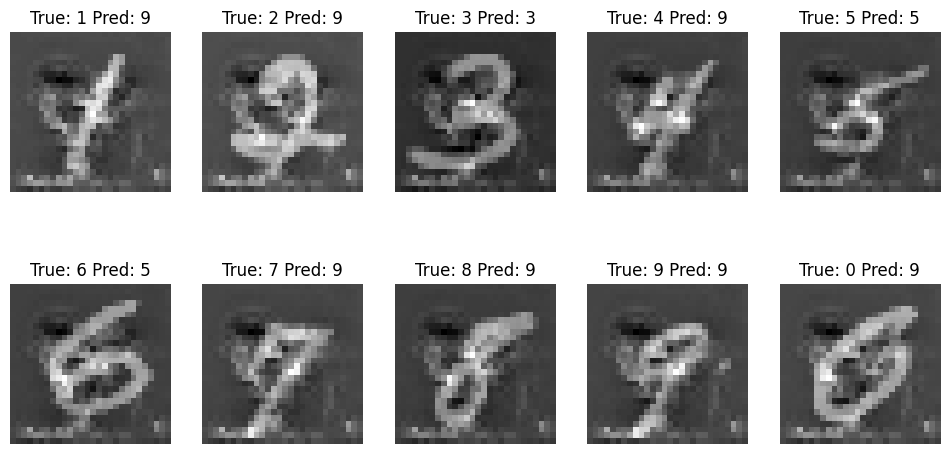

In [ ]:
# GENERIC CODE FOR ALL CLASSES

image=images[0].to(device)
label=labels[0].to(device)

#for all target i.e. 0,1,2,3,4,5,6,7,8,9
for target in range(10):
    print("TARGET CLASS: {}".format(target))
    noise1=torch.zeros((1,1,28,28),requires_grad=True,device='cuda')
    target_label=target
    optimizer = torch.optim.SGD([noise1],lr=0.001)
    fig = plt.figure(figsize=(10,6))
    for i in range(2000):
        optimizer.zero_grad()

        out_pred=model(image+noise1)
        loss=-out_pred[0][target_label]
        loss.backward()
        optimizer.step()

    prediction_vect_cpu = out_pred.detach().cpu().numpy()
    prediction_vect_cpu=np.squeeze(prediction_vect_cpu)

    prediction_prob_vect=np.exp(prediction_vect_cpu)/np.sum(np.exp(prediction_vect_cpu))

    predicted_digit=np.argmax(prediction_prob_vect)
    prediction_probability=prediction_prob_vect[predicted_digit]



    a= fig.add_subplot(1,3,1)
    a.title.set_text('Original Image')
    plt.imshow(np.squeeze(image.cpu().detach().numpy()),cmap='gray')



    b= fig.add_subplot(1,3,2)
    b.title.set_text('Noise')
    plt.imshow(np.squeeze(noise1.cpu().detach().numpy()),cmap='gray')

    c= fig.add_subplot(1,3,3)
    c.title.set_text('Predicted {} with Prob. {:.3f}'.format(predicted_digit,prediction_probability))
    plt.imshow(np.squeeze((image+noise1).cpu().detach().numpy()),cmap='gray')

    for images, labels in test_loader:
      images=images[9705:9715]
      labels=labels[9705:9715]
      noise1=noise1.cuda()
      images=images.cuda()
      images=images+noise1
      pred=model(images)
      predlabels=torch.max(pred,1)[1].cpu().numpy()
      fig=plt.figure(figsize=(12, 6))
      columns = 5
      rows = 2
      for i in range(1, columns*rows +1):
          fig.add_subplot(rows, columns, i) 
          trueval=labels[i-1].data.cpu().numpy()
          predval=predlabels[i-1]
          a='True: '+str(trueval)+' Pred: '+str(predval)
          plt.title(a)
          plt.axis('off')
          plt.imshow(images[i-1].reshape(-1,28).cpu().detach().numpy(), cmap='gray')
      plt.show()

In [ ]:
!pip install nbconvert
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!jupyter nbconvert --to html "PA2_EE21S060.ipynb"